In [2]:
!pip install dgl
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.7 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import torch
from torch_geometric.datasets import Planetoid

def load(name):
    if name == 'citeseer':
        dataset = Planetoid("/tmp/CitationFull", name="CiteSeer")
    elif name == 'CoraFull':
        dataset = Planetoid("/tmp/Cora", name="Cora")

    graph = dataset[0]
    N = graph.num_nodes

    train_ratio = 0.7
    val_ratio = 0.1
    test_ratio = 0.2

    num_train = int(N * train_ratio)
    num_val = int(N * val_ratio)
    num_test = N - (num_val + num_train)

    num_class = dataset.num_classes

    if name == 'citeseer':
        dataset = Planetoid("/tmp/CitationFull", name="CiteSeer",split="random",num_train_per_class= int(num_train/num_class) , num_val=num_val, num_test=num_test)
    elif name == 'CoraFull':
        dataset = Planetoid("/tmp/Cora", name="Cora", split="random",num_train_per_class= int(num_train/num_class), num_val=num_val, num_test=num_test)


    num_features =  dataset.num_features
    data = dataset[0]


    print(f"Num. nodes: {data.num_nodes} (train={data.train_mask.sum()}, val={data.val_mask.sum()}, test={data.test_mask.sum()})")
    print(f"Num Edges: {data.num_edges}")

    return dataset, data, num_class, num_features

## Implement MLP Model

In [6]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        layers = []
        sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(sizes) - 1):
            layers.append(torch.nn.Linear(sizes[i], sizes[i + 1]))
            if i < len(sizes) - 2:
                layers.append(torch.nn.ReLU())
        self.model = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [20]:
def mlp_model(dataset, num_class, num_features ):

  input_size = num_features
  hidden_sizes = [[1024, 256, 32],[1024,512,16],[1024,32],[512,128,32],[1024,128]]  # Adjust these according to your preference
  output_size = num_class

  best_acc = 0
  best_arch = None

  data = dataset[0]

  for hidden_size in hidden_sizes:

     model = MLP(input_size, hidden_size, output_size)

     criterion = torch.nn.CrossEntropyLoss()
     optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

     num_epochs = 20


     for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            out = model(data.x)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()

     model.eval()
     with torch.no_grad():
      out = model(data.x)
      _,pred = out.max(dim=1)
      correct = (pred[data.val_mask] == data.y[data.val_mask]).sum().item()
      val_acc = correct / data.val_mask.sum().item()

     if val_acc > best_acc :
        best_acc = val_acc
        model_scripted = torch.jit.script(model)
        model_scripted.save('best_mlp_model.pt')
        best_arch = hidden_size

  print(f"best hidden_size_layers: {best_arch}")
  model = torch.jit.load('best_mlp_model.pt')
  model.eval()
  with torch.no_grad():
      out = model(data.x)
      _,pred = out.max(dim=1)
      correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
      test_acc = correct / data.test_mask.sum().item()

  print(f"Accurac of best model on the test data: {test_acc}\nAccurac of best model on the val data: {val_acc}")


In [21]:
dataset, data, num_class, num_features = load('citeseer')
mlp_model(dataset, num_class, num_features)

Num. nodes: 3327 (train=2204, val=332, test=667)
Num Edges: 9104
best hidden_size_layers: [1024, 128]
Accurac of best model on the test data: 0.4497751124437781
Accurac of best model on the val data: 0.4307228915662651


In [22]:
dataset, data, num_class, num_features = load('CoraFull')
mlp_model(dataset, num_class, num_features)

Num. nodes: 2708 (train=1747, val=270, test=543)
Num Edges: 10556
best hidden_size_layers: [1024, 128]
Accurac of best model on the test data: 0.5211786372007366
Accurac of best model on the val data: 0.5962962962962963


## Implement GCN Model

In [33]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, dataset.num_classes)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)

        return F.log_softmax(x, dim=1)


class GCN2(torch.nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_size)
        self.conv2 = GCNConv(hidden_size, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GCN3(torch.nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)
        self.conv3 = GCNConv(hidden_size, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)

        return F.log_softmax(x, dim=1)
class GCN4(torch.nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, hidden_size)
        self.conv2 = GCNConv(hidden_size, hidden_size)
        self.conv3 = GCNConv(hidden_size, hidden_size)
        self.conv4 = GCNConv(hidden_size, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv4(x, edge_index)

        return F.log_softmax(x, dim=1)


In [37]:
import time
import pandas as pd

def gcn_model(data,name_dataset):
    hidden_sizes = [8,16, 32, 64, 128]  # Adjust these according to your preference

    num_epoch = 100
    res = []
    columns = ['Model', 'Num Layer', 'Hidden size', 'Time', 'Acc']

    for i in range(1, 5):

        best_acc = 0
        best_arch = None
        best_time = 0

        if i == 1:
            model = GCN1()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
            criterion = torch.nn.CrossEntropyLoss()
            startTime = time.time()
            model.train()
            for epoch in range(num_epoch):
                optimizer.zero_grad()
                out = model(data)
                loss = criterion(out[data.train_mask], data.y[data.train_mask])
                loss.backward()
                optimizer.step()
            totalTime = time.time() - startTime

            model.eval()
            with torch.no_grad():
                pred = model(data).argmax(dim=1)
                correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
                val_acc = correct / data.val_mask.sum().item()

            res.append(['GCN', i, 0, totalTime, val_acc])

            if val_acc > best_acc:
                best_acc = val_acc
                torch.save(model, f"./best_gcn{i}_model_{data.num_nodes}")
                best_time = totalTime

            model = torch.load(f"./best_gcn{i}_model_{data.num_nodes}")
            model.eval()
            with torch.no_grad():
                pred = model(data).argmax(dim=1)
                correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
                test_acc = correct / data.test_mask.sum().item()

            print(
                f"Best model accuracy with GCN on the test {name_dataset}: {test_acc:.2f}, on validation data:{best_acc:.2f}, depth :{i} time: {best_time:.2f}")

        else:

            for hidden_size in hidden_sizes:

                if i == 2:
                    model = GCN2(hidden_size)
                elif i == 3:
                    model = GCN3(hidden_size)
                elif i == 4:
                    model = GCN4(hidden_size)

                optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
                criterion = torch.nn.CrossEntropyLoss()

                startTime = time.time()
                model.train()
                for epoch in range(num_epoch):
                        optimizer.zero_grad()
                        out = model(data)
                        loss = criterion(out[data.train_mask], data.y[data.train_mask])
                        loss.backward()
                        optimizer.step()
                totalTime = time.time() - startTime

                model.eval()
                with torch.no_grad():
                    pred = model(data).argmax(dim=1)
                    correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
                    val_acc = correct / data.val_mask.sum().item()

                res.append(['GCN', i, hidden_size, totalTime, val_acc])

                if val_acc > best_acc:
                    best_acc = val_acc
                    torch.save(model, f"./best_gcn{i}_model_{data.num_nodes}")
                    best_time = totalTime
                    best_arch = hidden_size


            model = torch.load(f"./best_gcn{i}_model_{data.num_nodes}")
            model.eval()
            with torch.no_grad():
                    pred = model(data).argmax(dim=1)
                    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
                    test_acc = correct / data.test_mask.sum().item()

            print(
                f"Best model accuracy with GCN on the test {name_dataset}: {test_acc:.2f}, on validation data:{best_acc:.2f}, depth :{i} time: {best_time:.2f} hidden size : {best_arch}")

    df = pd.DataFrame.from_records(res, columns=columns)
    df.to_csv(f"/content/drive/MyDrive/gcn_{name_dataset}")

    return df


In [40]:
dataset, data, num_class, num_features = load('citeseer')
gcn_model(data, 'citeseer')

Num. nodes: 3327 (train=2204, val=332, test=667)
Num Edges: 9104
Best model accuracy with GCN on the test citeseer: 0.76, on validation data:0.77, depth :1 time: 2.28
Best model accuracy with GCN on the test citeseer: 0.78, on validation data:0.78, depth :2 time: 2.75 hidden size : 8
Best model accuracy with GCN on the test citeseer: 0.78, on validation data:0.79, depth :3 time: 3.67 hidden size : 16
Best model accuracy with GCN on the test citeseer: 0.75, on validation data:0.79, depth :4 time: 6.04 hidden size : 64


Model  Num Layer  Hidden size       Time             Acc
0    GCN          1            0   2.284725  tensor(0.7651)
1    GCN          2            8   2.748366  tensor(0.7801)
2    GCN          2           16   2.579752  tensor(0.7801)
3    GCN          2           32   3.399056  tensor(0.7711)
4    GCN          2           64   5.364383  tensor(0.7681)
5    GCN          2          128   8.820787  tensor(0.7651)
6    GCN          3            8   2.550669  tensor(0.7771)
7    GCN          3           16   3.665112  tensor(0.7861)
8    GCN          3           32   3.746516  tensor(0.7590)
9    GCN          3           64   5.359400  tensor(0.7681)
10   GCN          3          128  10.624085  tensor(0.7590)
11   GCN          4            8   2.881946  tensor(0.5843)
12   GCN          4           16   3.895824  tensor(0.7711)
13   GCN          4           32   4.278625  tensor(0.7651)
14   GCN          4           64   6.041413  tensor(0.7861)
15   GCN          4          128  11.960806  tensor(0.7590)

In [42]:
dataset, data, num_class, num_features = load('CoraFull')
gcn_model(data, 'CoraFull')

Num. nodes: 2708 (train=1747, val=270, test=543)
Num Edges: 10556
Best model accuracy with GCN on the test CoraFull: 0.84, on validation data:0.82, depth :1 time: 1.10
Best model accuracy with GCN on the test CoraFull: 0.89, on validation data:0.89, depth :2 time: 2.05 hidden size : 64
Best model accuracy with GCN on the test CoraFull: 0.88, on validation data:0.89, depth :3 time: 2.80 hidden size : 64
Best model accuracy with GCN on the test CoraFull: 0.87, on validation data:0.88, depth :4 time: 2.39 hidden size : 32


Model  Num Layer  Hidden size      Time             Acc
0    GCN          1            0  1.100665  tensor(0.8222)
1    GCN          2            8  1.509916  tensor(0.7111)
2    GCN          2           16  1.151424  tensor(0.8704)
3    GCN          2           32  1.390690  tensor(0.8815)
4    GCN          2           64  2.047187  tensor(0.8852)
5    GCN          2          128  3.687263  tensor(0.8852)
6    GCN          3            8  1.376899  tensor(0.8333)
7    GCN          3           16  2.050985  tensor(0.8519)
8    GCN          3           32  2.260339  tensor(0.8741)
9    GCN          3           64  2.804564  tensor(0.8889)
10   GCN          3          128  4.808975  tensor(0.8778)
11   GCN          4            8  1.725201  tensor(0.4815)
12   GCN          4           16  2.457516  tensor(0.8630)
13   GCN          4           32  2.391442  tensor(0.8815)
14   GCN          4           64  3.479509  tensor(0.8778)
15   GCN          4          128  6.655985  tensor(0.8741)

##GAT

In [5]:
from torch_geometric.nn import GATConv
import torch
import torch.nn.functional as F

class GAT1(torch.nn.Module):
    def __init__(self, heads):
        super().__init__()
        self.conv1 = GATConv(dataset.num_node_features, dataset.num_classes, heads)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        return F.log_softmax(x, dim=1)


class GAT2(torch.nn.Module):
    def __init__(self,hidden_channels, heads):
        super().__init__()
        self.conv1 = GATConv(dataset.num_node_features, hidden_channels, heads, dropout=0.5)
        self.conv2 = GATConv(hidden_channels * heads, dataset.num_classes, heads)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GAT3(torch.nn.Module):
    def __init__(self,hidden_channels, heads):
        super().__init__()
        self.conv1 = GATConv(dataset.num_node_features, hidden_channels, heads, dropout=0.5)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads, dropout=0.5)
        self.conv3 = GATConv(hidden_channels * heads, dataset.num_classes, heads)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

class GAT4(torch.nn.Module):
    def __init__(self,hidden_channels, heads):
        super().__init__()
        self.conv1 = GATConv(dataset.num_node_features, hidden_channels, heads, dropout=0.5)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads, dropout=0.5)
        self.conv3 = GATConv(hidden_channels * heads, hidden_channels, heads, dropout=0.5)
        self.conv4 = GATConv(hidden_channels * heads, dataset.num_classes, heads)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)

In [54]:
import time
import pandas as pd

def gat_model(dataset,name_dataset):
    hidden_sizes = [8,16, 32, 64, 128]  # Adjust these according to your preference

    num_epoch = 100
    res = []
    columns = ['Model', 'Num Layer', 'Hidden size','Head', 'Time', 'Acc']
    heads = [1,2,3,5,10]

    data = dataset[0]

    for i in range(1, 5):

        best_acc = 0
        best_arch = None
        best_time = 0
        best_head = None

        for head in heads:

            if i == 1:
                model = GAT1(head)
                optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
                criterion = torch.nn.CrossEntropyLoss()
                startTime = time.time()
                model.train()
                for epoch in range(num_epoch):
                    optimizer.zero_grad()
                    out = model(data)
                    loss = criterion(out[data.train_mask], data.y[data.train_mask])
                    loss.backward()
                    optimizer.step()
                totalTime = time.time() - startTime

                model.eval()
                with torch.no_grad():
                    pred = model(data).argmax(dim=1)
                    correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
                    val_acc = correct / data.val_mask.sum().item()

                res.append(['GAT', i, 0 , head, totalTime, val_acc])

                if val_acc > best_acc:
                    best_acc = val_acc
                    torch.save(model, f"./best_gat{i}_model_{data.num_nodes}")
                    best_time = totalTime
                    best_head = head
                    best_arch = 0

            else:

                for hidden_size in hidden_sizes:

                    if i == 2:
                        model = GAT2(hidden_size,head)
                    elif i == 3:
                        model = GAT3(hidden_size,head)
                    elif i == 4:
                        model = GAT4(hidden_size,head)

                    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
                    criterion = torch.nn.CrossEntropyLoss()

                    startTime = time.time()
                    model.train()
                    for epoch in range(num_epoch):
                            optimizer.zero_grad()
                            out = model(data)
                            loss = criterion(out[data.train_mask], data.y[data.train_mask])
                            loss.backward()
                            optimizer.step()
                    totalTime = time.time() - startTime

                    model.eval()
                    with torch.no_grad():
                        pred = model(data).argmax(dim=1)
                        correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
                        val_acc = correct / data.val_mask.sum().item()

                    res.append(['GAT', i, hidden_size,head, totalTime, val_acc])

                    if val_acc > best_acc:
                        best_acc = val_acc
                        torch.save(model, f"./best_gat{i}_model_{data.num_nodes}")
                        best_time = totalTime
                        best_arch = hidden_size
                        best_head = head


        model = torch.load(f"./best_gat{i}_model_{data.num_nodes}")
        model.eval()
        with torch.no_grad():
                    pred = model(data).argmax(dim=1)
                    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
                    test_acc = correct / data.test_mask.sum().item()

        print(
                f"Best model accuracy with GAT on the test {name_dataset}: {test_acc:.2f}, on validation data: {best_acc:.2f}, depth:{i}, time: {best_time:.2f}, hidden size: {best_arch}, head: {best_head}")

    df = pd.DataFrame.from_records(res, columns=columns)
    df.to_csv(f"/content/drive/MyDrive/gat_{name_dataset}")

    return df

In [55]:
dataset, data, num_class, num_features = load('citeseer')
gat_model(dataset, 'citeseer')

Num. nodes: 3327 (train=2204, val=332, test=667)
Num Edges: 9104
Best model accuracy with GAT on the test citeseer: 0.76, on validation data: 0.78, depth:1, time: 2.28, hidden size: 0, head: 1
Best model accuracy with GAT on the test citeseer: 0.78, on validation data: 0.77, depth:2, time: 5.35, hidden size: 8, head: 5
Best model accuracy with GAT on the test citeseer: 0.78, on validation data: 0.77, depth:3, time: 7.20, hidden size: 8, head: 5
Best model accuracy with GAT on the test citeseer: 0.78, on validation data: 0.77, depth:4, time: 5.06, hidden size: 16, head: 1


Model  Num Layer  Hidden size  Head        Time             Acc
0    GAT          1            0     1    2.282115  tensor(0.7801)
1    GAT          1            0     2    2.802525  tensor(0.7741)
2    GAT          1            0     3    3.277696  tensor(0.7620)
3    GAT          1            0     5    4.929559  tensor(0.7500)
4    GAT          1            0    10    6.374526  tensor(0.7560)
..   ...        ...          ...   ...         ...             ...
75   GAT          4            8    10   12.960687  tensor(0.7229)
76   GAT          4           16    10   20.219193  tensor(0.7108)
77   GAT          4           32    10   36.607038  tensor(0.6898)
78   GAT          4           64    10   76.952692  tensor(0.7078)
79   GAT          4          128    10  200.779372  tensor(0.7018)

[80 rows x 6 columns]

In [56]:
dataset, data, num_class, num_features = load('CoraFull')
gat_model(dataset, 'CoraFull')

Num. nodes: 2708 (train=1747, val=270, test=543)
Num Edges: 10556
Best model accuracy with GAT on the test CoraFull: 0.85, on validation data: 0.81, depth:1, time: 1.45, hidden size: 0, head: 2
Best model accuracy with GAT on the test CoraFull: 0.87, on validation data: 0.89, depth:2, time: 8.51, hidden size: 16, head: 10
Best model accuracy with GAT on the test CoraFull: 0.89, on validation data: 0.89, depth:3, time: 3.17, hidden size: 32, head: 1
Best model accuracy with GAT on the test CoraFull: 0.87, on validation data: 0.89, depth:4, time: 21.45, hidden size: 64, head: 5


Model  Num Layer  Hidden size  Head        Time             Acc
0    GAT          1            0     1    1.020322  tensor(0.7963)
1    GAT          1            0     2    1.448515  tensor(0.8111)
2    GAT          1            0     3    1.546575  tensor(0.7519)
3    GAT          1            0     5    2.262192  tensor(0.7519)
4    GAT          1            0    10    4.338243  tensor(0.7963)
..   ...        ...          ...   ...         ...             ...
75   GAT          4            8    10   10.050946  tensor(0.8741)
76   GAT          4           16    10   14.097549  tensor(0.8704)
77   GAT          4           32    10   23.518703  tensor(0.8630)
78   GAT          4           64    10   47.434124  tensor(0.8778)
79   GAT          4          128    10  136.189073  tensor(0.8593)

[80 rows x 6 columns]

## GATv2

In [6]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv

class GATv21(torch.nn.Module):
    def __init__(self, num_heads):
        super().__init__()
        self.conv1 = GATv2Conv(dataset.num_node_features, dataset.num_classes, heads=num_heads)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        return F.log_softmax(x, dim=1)

class GATv22(torch.nn.Module):
    def __init__(self,  hidden_channels, num_heads):
        super().__init__()
        self.conv1 = GATv2Conv(dataset.num_node_features, hidden_channels, heads=num_heads, dropout=0.5)
        self.conv2 = GATv2Conv(hidden_channels * num_heads, dataset.num_classes, heads=num_heads)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

class GATv23(torch.nn.Module):
    def __init__(self,  hidden_channels, num_heads):
        super().__init__()
        self.conv1 = GATv2Conv(dataset.num_node_features, hidden_channels, heads=num_heads, dropout=0.5)
        self.conv2 = GATv2Conv(hidden_channels * num_heads, hidden_channels, heads=num_heads, dropout=0.5)
        self.conv3 = GATv2Conv(hidden_channels * num_heads, dataset.num_classes, heads=num_heads)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

class GATv24(torch.nn.Module):
    def __init__(self,  hidden_channels, num_heads):
        super().__init__()
        self.conv1 = GATv2Conv(dataset.num_node_features, hidden_channels, heads=num_heads, dropout=0.5)
        self.conv2 = GATv2Conv(hidden_channels * num_heads, hidden_channels, heads=num_heads, dropout=0.5)
        self.conv3 = GATv2Conv(hidden_channels * num_heads, hidden_channels, heads=num_heads, dropout=0.5)
        self.conv4 = GATv2Conv(hidden_channels * num_heads, dataset.num_classes, heads=num_heads)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = self.conv4(x, edge_index)
        return F.log_softmax(x, dim=1)


In [7]:
import time
import pandas as pd

def gatv2_model(dataset,name_dataset):
    hidden_sizes = [8,16, 32, 64, 128]  # Adjust these according to your preference

    num_epoch = 100
    res = []
    columns = ['Model', 'Num Layer', 'Hidden size','Head', 'Time', 'Acc']
    heads = [1,2,3,5,10]
    data = dataset[0]

    for i in range(1, 5):

        best_acc = 0
        best_arch = None
        best_time = 0
        best_head = None

        for head in heads:

            if i == 1:
                model = GATv21(head)
                optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
                criterion = torch.nn.CrossEntropyLoss()
                startTime = time.time()
                model.train()
                for epoch in range(num_epoch):
                    optimizer.zero_grad()
                    out = model(data)
                    loss = criterion(out[data.train_mask], data.y[data.train_mask])
                    loss.backward()
                    optimizer.step()
                totalTime = time.time() - startTime

                model.eval()
                with torch.no_grad():
                    pred = model(data).argmax(dim=1)
                    correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
                    val_acc = correct / data.val_mask.sum().item()

                res.append(['GATv2', i, 0 , head, totalTime, val_acc])

                if val_acc > best_acc:
                    best_acc = val_acc
                    torch.save(model, f"./best_gatv2{i}_model_{data.num_nodes}")
                    best_time = totalTime
                    best_head = head
                    best_arch = 0

            else:

                for hidden_size in hidden_sizes:

                    if i == 2:
                        model = GATv22(hidden_size,head)
                    elif i == 3:
                        model = GATv23(hidden_size,head)
                    elif i == 4:
                        model = GATv24(hidden_size,head)

                    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
                    criterion = torch.nn.CrossEntropyLoss()

                    startTime = time.time()
                    model.train()
                    for epoch in range(num_epoch):
                            optimizer.zero_grad()
                            out = model(data)
                            loss = criterion(out[data.train_mask], data.y[data.train_mask])
                            loss.backward()
                            optimizer.step()
                    totalTime = time.time() - startTime

                    model.eval()
                    with torch.no_grad():
                        pred = model(data).argmax(dim=1)
                        correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
                        val_acc = correct / data.val_mask.sum().item()

                    res.append(['GATv2', i, hidden_size,head, totalTime, val_acc])

                    if val_acc > best_acc:
                        best_acc = val_acc
                        torch.save(model, f"./best_gatv2{i}_model_{data.num_nodes}")
                        best_time = totalTime
                        best_arch = hidden_size
                        best_head = head


        model = torch.load(f"./best_gatv2{i}_model_{data.num_nodes}")
        model.eval()
        with torch.no_grad():
                    pred = model(data).argmax(dim=1)
                    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
                    test_acc = correct / data.test_mask.sum().item()

        print(
                f"Best model accuracy with GATv2 on the test {name_dataset}: {test_acc:.2f} , on validation data: {best_acc:.2f}, depth :{i}, time: {best_time:.2f}, hidden size: {best_arch}, head: {best_head}")

    df = pd.DataFrame.from_records(res, columns=columns)
    df.to_csv(f"/content/drive/MyDrive/gatv2_{name_dataset}")

    return df

In [60]:
dataset, data, num_class, num_features = load('citeseer')
gatv2_model(dataset, 'citeseer')


Num. nodes: 3327 (train=2204, val=332, test=667)
Num Edges: 9104
Best model accuracy with GATv2 on the test citeseer: 0.78 , on validation data: 0.78, depth :1, time: 5.67, hidden size: 0, head: 2
Best model accuracy with GATv2 on the test citeseer: 0.79 , on validation data: 0.82, depth :2, time: 8.56, hidden size: 8, head: 2
Best model accuracy with GATv2 on the test citeseer: 0.79 , on validation data: 0.79, depth :3, time: 8.25, hidden size: 8, head: 3
Best model accuracy with GATv2 on the test citeseer: 0.76 , on validation data: 0.79, depth :4, time: 7.29, hidden size: 16, head: 1


Model  Num Layer  Hidden size  Head        Time             Acc
0   GATv2          1            0     1    4.470460  tensor(0.7741)
1   GATv2          1            0     2    5.673295  tensor(0.7831)
2   GATv2          1            0     3    5.636805  tensor(0.7771)
3   GATv2          1            0     5    7.562812  tensor(0.7741)
4   GATv2          1            0    10   11.168551  tensor(0.7681)
..    ...        ...          ...   ...         ...             ...
75  GATv2          4            8    10   19.971381  tensor(0.7741)
76  GATv2          4           16    10   35.284985  tensor(0.7801)
77  GATv2          4           32    10   64.519280  tensor(0.7711)
78  GATv2          4           64    10  142.479826  tensor(0.7440)
79  GATv2          4          128    10  410.907895  tensor(0.7560)

[80 rows x 6 columns]

In [8]:
dataset, data, num_class, num_features = load('CoraFull')
gatv2_model(dataset, 'CoraFull')

Processing...
Done!


Num. nodes: 2708 (train=1747, val=270, test=543)
Num Edges: 10556
Best model accuracy with GATv2 on the test CoraFull: 0.83 , on validation data: 0.82, depth :1, time: 6.34, hidden size: 0, head: 5
Best model accuracy with GATv2 on the test CoraFull: 0.87 , on validation data: 0.89, depth :2, time: 163.60, hidden size: 128, head: 10
Best model accuracy with GATv2 on the test CoraFull: 0.88 , on validation data: 0.88, depth :3, time: 4.74, hidden size: 16, head: 1
Best model accuracy with GATv2 on the test CoraFull: 0.87 , on validation data: 0.90, depth :4, time: 8.83, hidden size: 16, head: 2


Model  Num Layer  Hidden size  Head        Time             Acc
0   GATv2          1            0     1   10.545290  tensor(0.8037)
1   GATv2          1            0     2    3.595228  tensor(0.7630)
2   GATv2          1            0     3    4.060154  tensor(0.7889)
3   GATv2          1            0     5    6.341660  tensor(0.8185)
4   GATv2          1            0    10    9.356549  tensor(0.8111)
..    ...        ...          ...   ...         ...             ...
75  GATv2          4            8    10   22.224845  tensor(0.8778)
76  GATv2          4           16    10   34.291233  tensor(0.8519)
77  GATv2          4           32    10   72.721778  tensor(0.8444)
78  GATv2          4           64    10  196.460575  tensor(0.8407)
79  GATv2          4          128    10  512.248071  tensor(0.8296)

[80 rows x 6 columns]

## Analysis

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_hidden_layer(dataset_name,type1):

      df_gatv2 = pd.read_csv(f'/content/drive/MyDrive/gatv2_{dataset_name}')
      df_gat = pd.read_csv(f'/content/drive/MyDrive/gat_{dataset_name}')
      df_gcn = pd.read_csv(f'/content/drive/MyDrive/gcn_{dataset_name}')

      df_gcn["Acc"] = df_gcn["Acc"].str.replace('tensor\(', '').str.replace('\)', '').astype(float)
      df_gat["Acc"] = df_gatv2["Acc"].str.replace('tensor\(', '').str.replace('\)', '').astype(float)
      df_gatv2["Acc"] = df_gatv2["Acc"].str.replace('tensor\(', '').str.replace('\)', '').astype(float)


      numerical_columns = ["Hidden size", type1]

      #GCN
      fig, axs = plt.subplots(1,3,figsize=(15,5))
      fig.suptitle(f"{type1} vs Hidden Size in GCN\n")
      # Plot lines for each head
      for i in range(2,5):
              df_filtered = df_gcn[(df_gcn['Num Layer']==i) ]
              axs[i-2].plot(df_filtered[numerical_columns[0]], df_filtered[numerical_columns[1]])
              axs[i-2].set_title(f"Num Layer: {i}")

              # Set labels and title
              axs[i-2].set_xlabel(numerical_columns[0])
              axs[i-2].set_ylabel(numerical_columns[1])

              axs[i-2].legend()
      fig.tight_layout()
      # Show the plot
      plt.show()

      #GAT
      fig, axs = plt.subplots(1,3,figsize=(15, 5))
      fig.suptitle(f"{type1} vs Hidden Size in GAT\n")
      # Plot lines for each head
      for i in range(2,5):
          for head in df_gat['Head'].unique():
              df_filtered = df_gat[ (df_gat['Head'] == head) & (df_gat['Num Layer']==i) ]
              axs[i-2].plot(df_filtered[numerical_columns[0]], df_filtered[numerical_columns[1]], label=f"Head {head}")
              axs[i-2].set_title(f"Num Layer: {i}")

          # Set labels and title
          axs[i-2].set_xlabel(numerical_columns[0])
          axs[i-2].set_ylabel(numerical_columns[1])

          axs[i-2].legend()
      fig.tight_layout()
      # Show the plot
      plt.show()

      #GATv2


      fig, axs = plt.subplots(1,3,figsize=(15, 5))
      fig.suptitle(f"{type1} vs Hidden Size in GATv2\n")
      # Plot lines for each head
      for i in range(2,5):
          for head in df_gatv2['Head'].unique():
              df_filtered = df_gatv2[ (df_gatv2['Head'] == head) & (df_gatv2['Num Layer']==i) ]
              axs[i-2].plot(df_filtered[numerical_columns[0]], df_filtered[numerical_columns[1]], label=f"Head {head}")
              axs[i-2].set_title(f"Num Layer: {i}")

          # Set labels and title
          axs[i-2].set_xlabel(numerical_columns[0])
          axs[i-2].set_ylabel(numerical_columns[1])

          axs[i-2].legend()
      fig.tight_layout()
      # Show the plot
      plt.show()

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_head(dataset_name,type1):

      df_gatv2 = pd.read_csv(f'/content/drive/MyDrive/gatv2_{dataset_name}')
      df_gat = pd.read_csv(f'/content/drive/MyDrive/gat_{dataset_name}')

      df_gat["Acc"] = df_gatv2["Acc"].str.replace('tensor\(', '').str.replace('\)', '').astype(float)
      df_gatv2["Acc"] = df_gatv2["Acc"].str.replace('tensor\(', '').str.replace('\)', '').astype(float)


      numerical_columns = ["Head", type1]


      #GAT
      fig, axs = plt.subplots(1,4,figsize=(20, 5))
      fig.suptitle(f"{type1} vs Head in GAT\n")
      for i in range(1,5):
          for h in df_gat['Hidden size'].unique():
              df_filtered = df_gat[ (df_gat['Hidden size'] == h) & (df_gat['Num Layer']==i) ]
              axs[i-1].plot(df_filtered[numerical_columns[0]], df_filtered[numerical_columns[1]], label=f"Hidden size {h}")
              axs[i-1].set_title(f"Num Layer: {i}")

          # Set labels and title
          axs[i-1].set_xlabel(numerical_columns[0])
          axs[i-1].set_ylabel(numerical_columns[1])

          axs[i-1].legend()
      fig.tight_layout()
      # Show the plot
      plt.show()

      #GATv2


      fig, axs = plt.subplots(1,4,figsize=(20, 5))
      fig.suptitle(f"{type1} vs Head in GATv2\n")
      # Plot lines for each head
      for i in range(1,5):
          for h in df_gatv2['Hidden size'].unique():
              df_filtered = df_gatv2[ (df_gatv2['Hidden size'] == h) & (df_gatv2['Num Layer']==i) ]
              axs[i-1].plot(df_filtered[numerical_columns[0]], df_filtered[numerical_columns[1]], label=f"Hidden size {h}")
              axs[i-1].set_title(f"Num Layer: {i}")

          # Set labels and title
          axs[i-1].set_xlabel(numerical_columns[0])
          axs[i-1].set_ylabel(numerical_columns[1])

          axs[i-1].legend()
      fig.tight_layout()
      # Show the plot
      plt.show()

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_depth_head(dataset_name,type1):

      df_gatv2 = pd.read_csv(f'/content/drive/MyDrive/gatv2_{dataset_name}')
      df_gat = pd.read_csv(f'/content/drive/MyDrive/gat_{dataset_name}')

      df_gat["Acc"] = df_gatv2["Acc"].str.replace('tensor\(', '').str.replace('\)', '').astype(float)
      df_gatv2["Acc"] = df_gatv2["Acc"].str.replace('tensor\(', '').str.replace('\)', '').astype(float)


      numerical_columns = ["Num Layer", type1]


      #GAT
      fig, axs = plt.subplots(1,5,figsize=(25,5))
      fig.suptitle(f"{type1} vs Depth in GAT\n")
      # Plot lines for each head
      for i , v in enumerate([1,2,3,5,10]):
        for h in [8,16, 32, 64, 128]:
              df_filtered = df_gat[(df_gat['Hidden size'] == h) & (df_gat['Head']==v) ]
              axs[i].plot(df_filtered[numerical_columns[0]], df_filtered[numerical_columns[1]], label=f"Hidden size {h}")
              axs[i].set_title(f"Head: {v}")

              # Set labels and title
              axs[i].set_xlabel(numerical_columns[0])
              axs[i].set_ylabel(numerical_columns[1])

              axs[i].legend()
      fig.tight_layout()

      #GATv2


      fig, axs = plt.subplots(1,5,figsize=(25,5))
      fig.suptitle(f"{type1} vs Depth in GAT\n")
      # Plot lines for each head
      for i , v in enumerate([1,2,3,5,10]):
        for h in [8,16, 32, 64, 128]:
              df_filtered = df_gatv2[(df_gatv2['Hidden size'] == h) & (df_gatv2['Head']==v) ]
              axs[i].plot(df_filtered[numerical_columns[0]], df_filtered[numerical_columns[1]], label=f"Hidden size {h}")
              axs[i].set_title(f"Head: {v}")

              # Set labels and title
              axs[i].set_xlabel(numerical_columns[0])
              axs[i].set_ylabel(numerical_columns[1])

              axs[i].legend()
      fig.tight_layout()
      # Show the plot
      plt.show()

### Citeseer

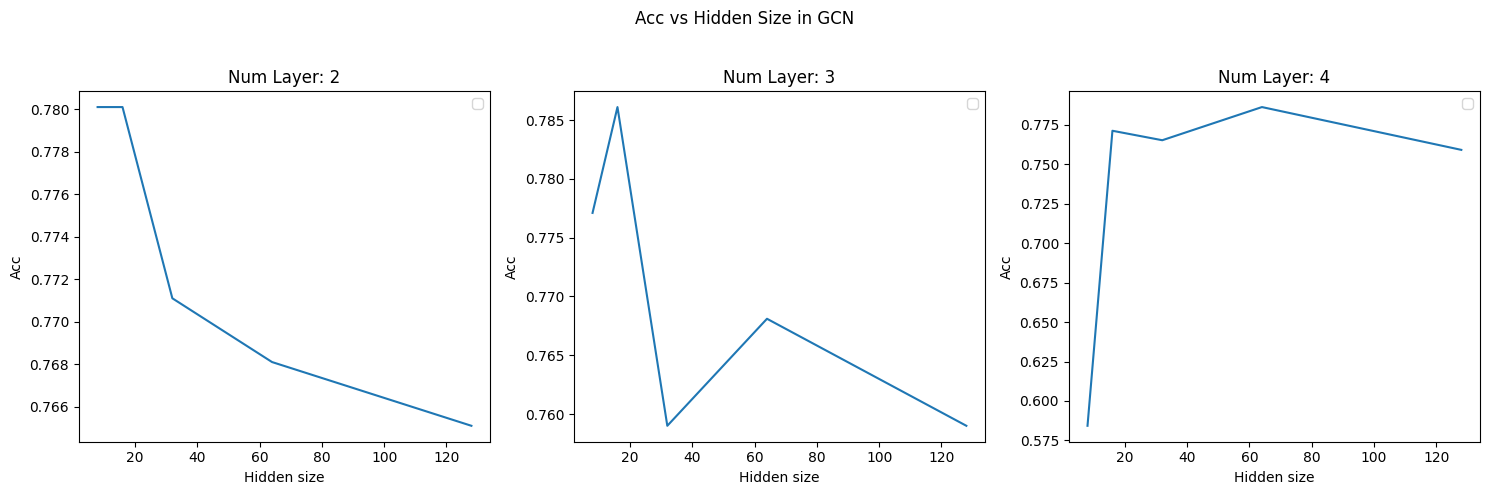

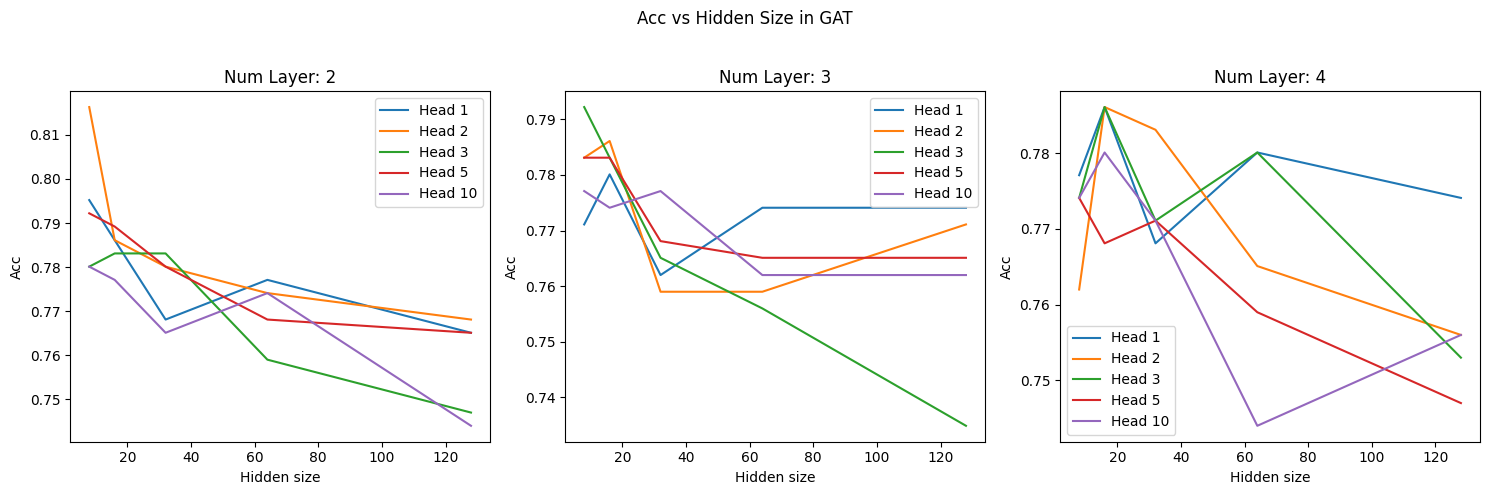

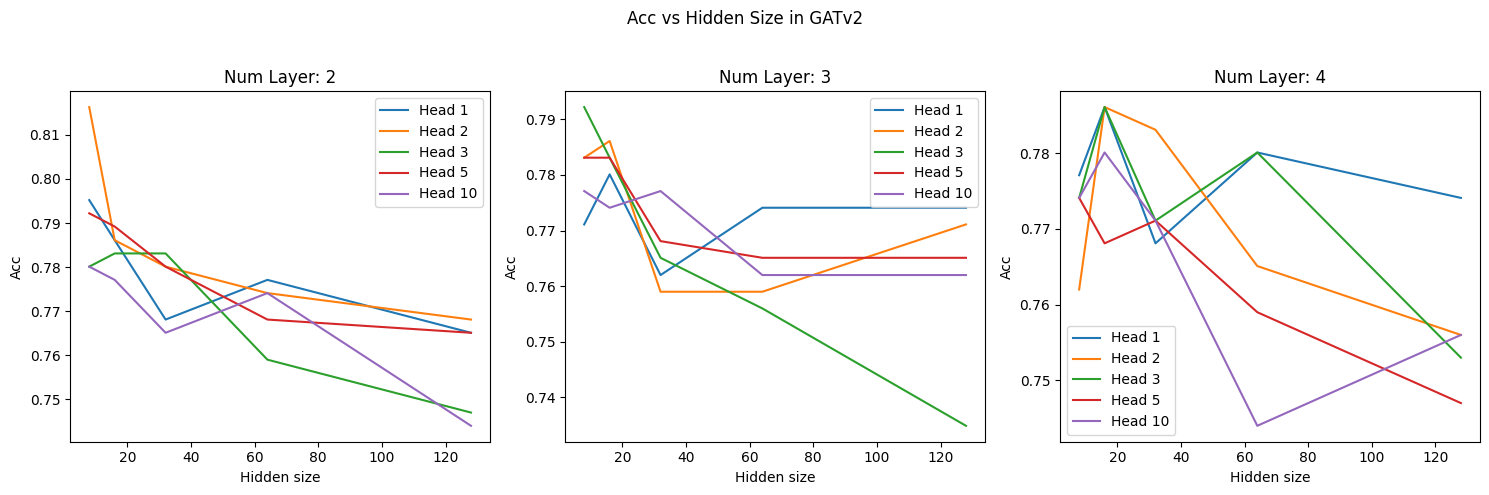

In [14]:
plot_hidden_layer('citeseer','Acc')

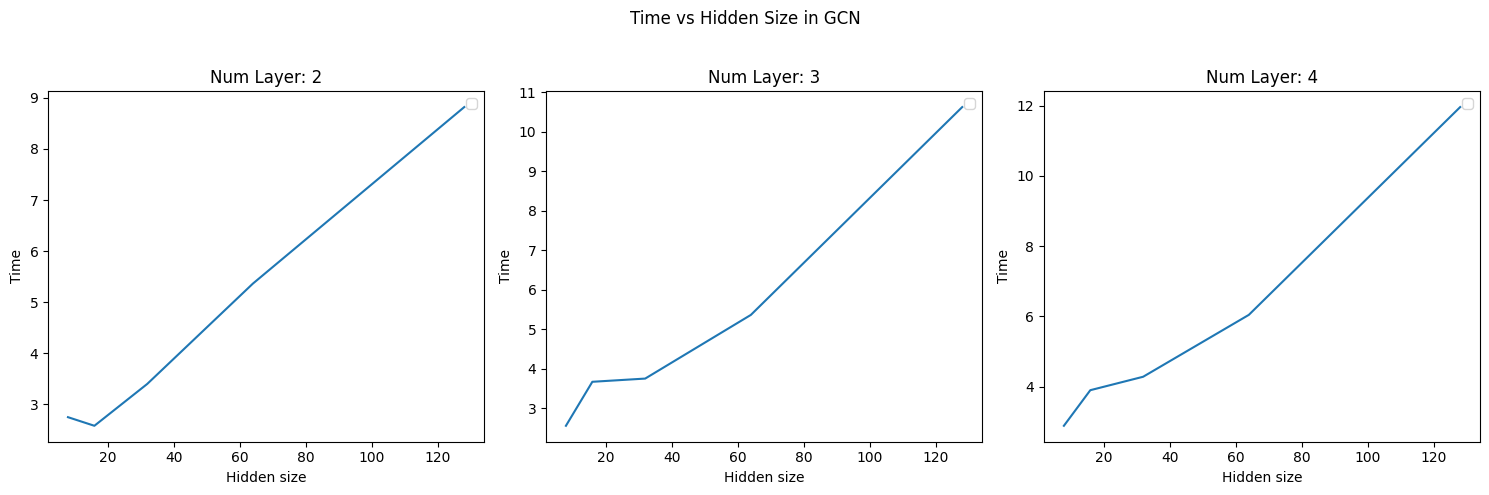

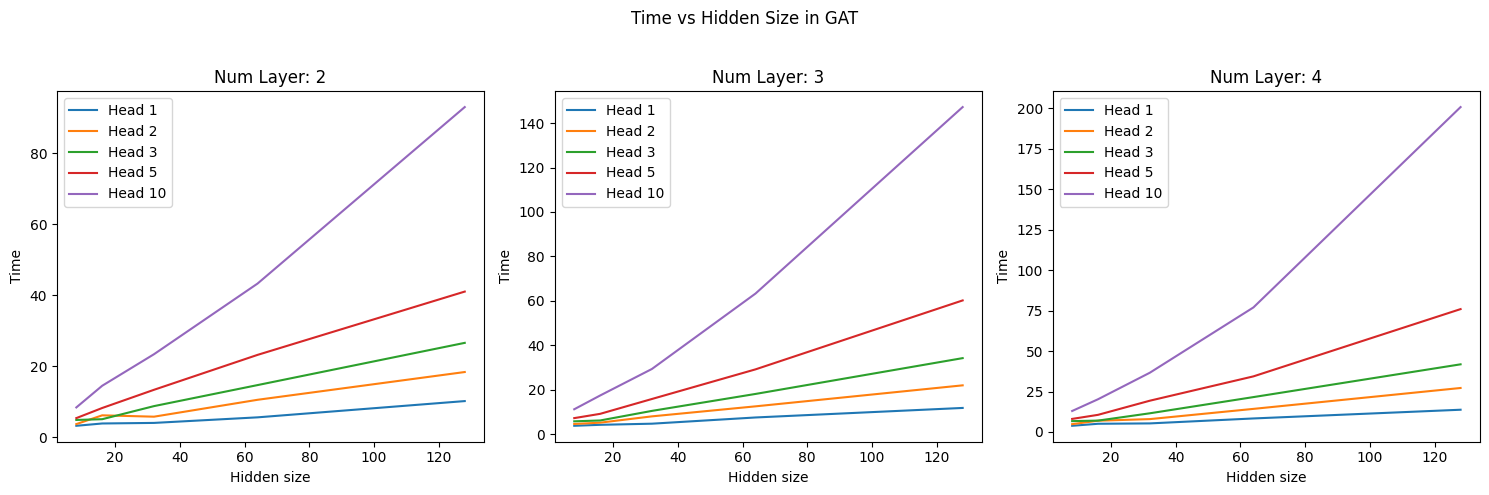

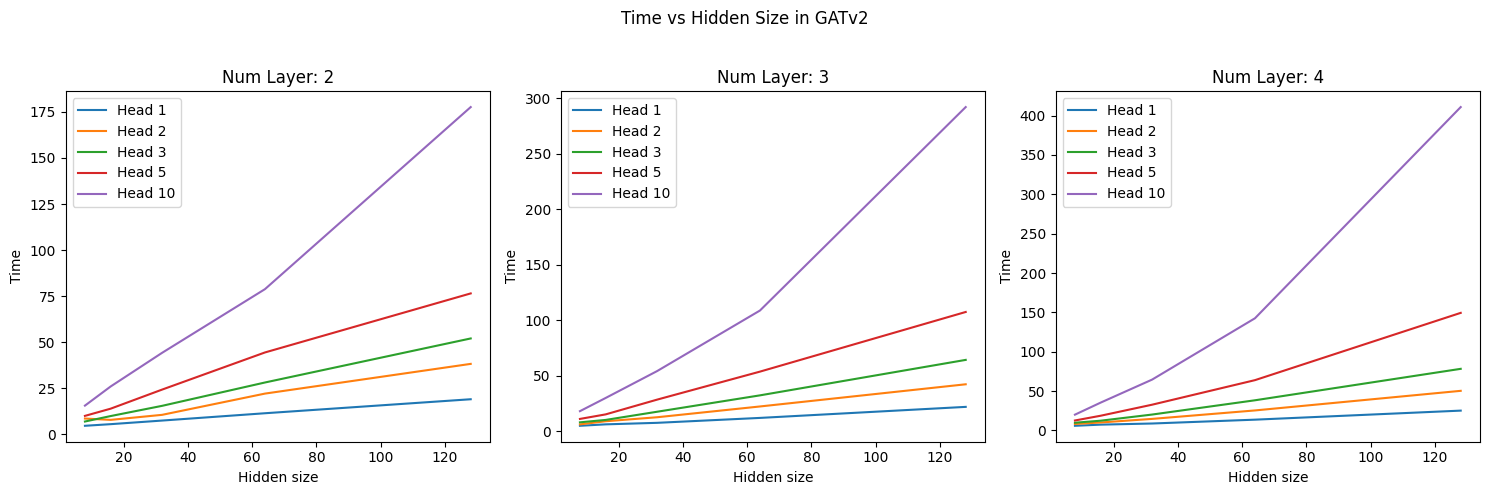

In [15]:
plot_hidden_layer('citeseer','Time')

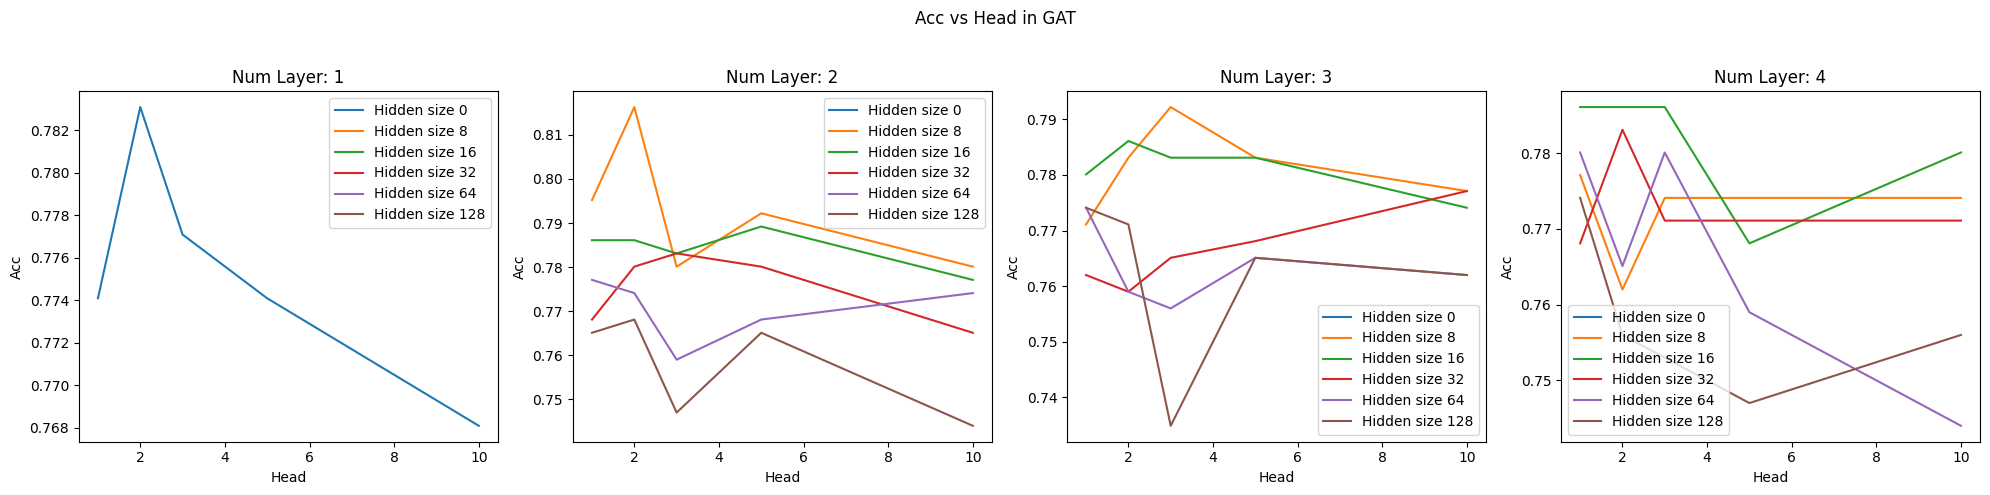

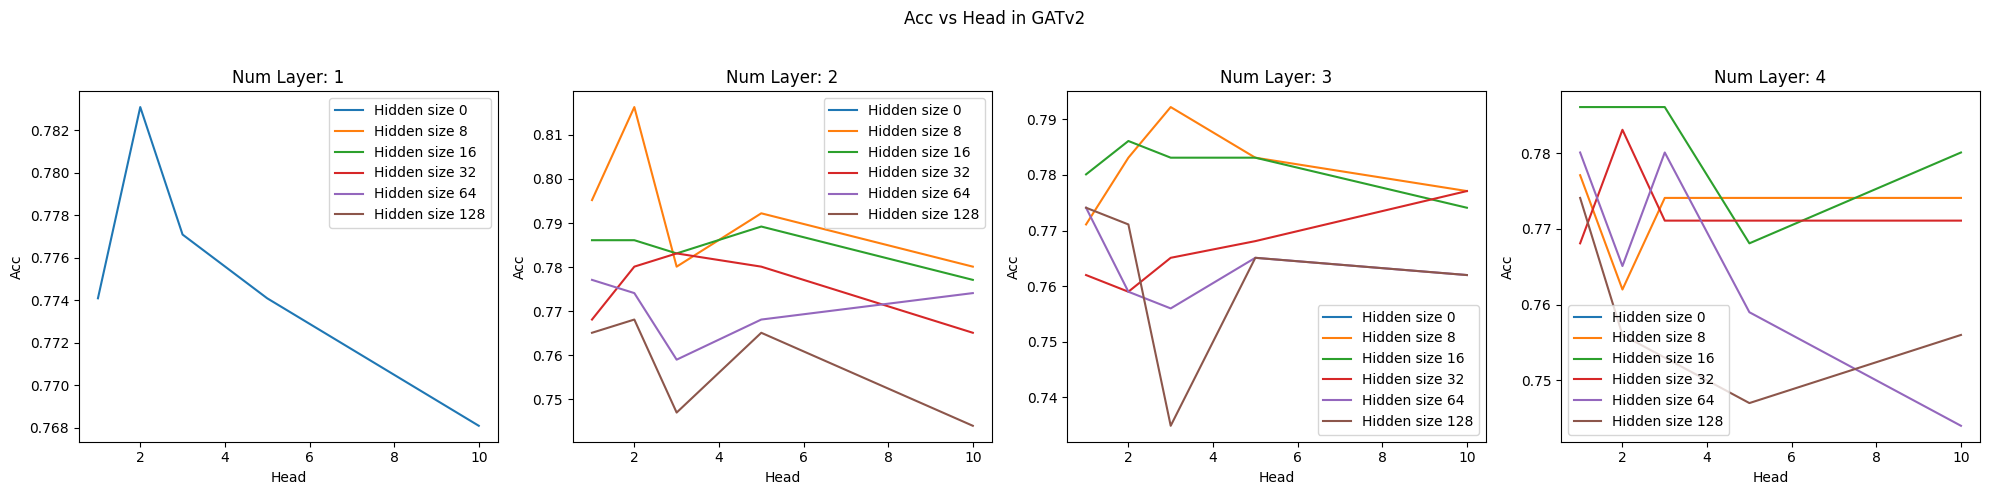

In [16]:
plot_head('citeseer','Acc')

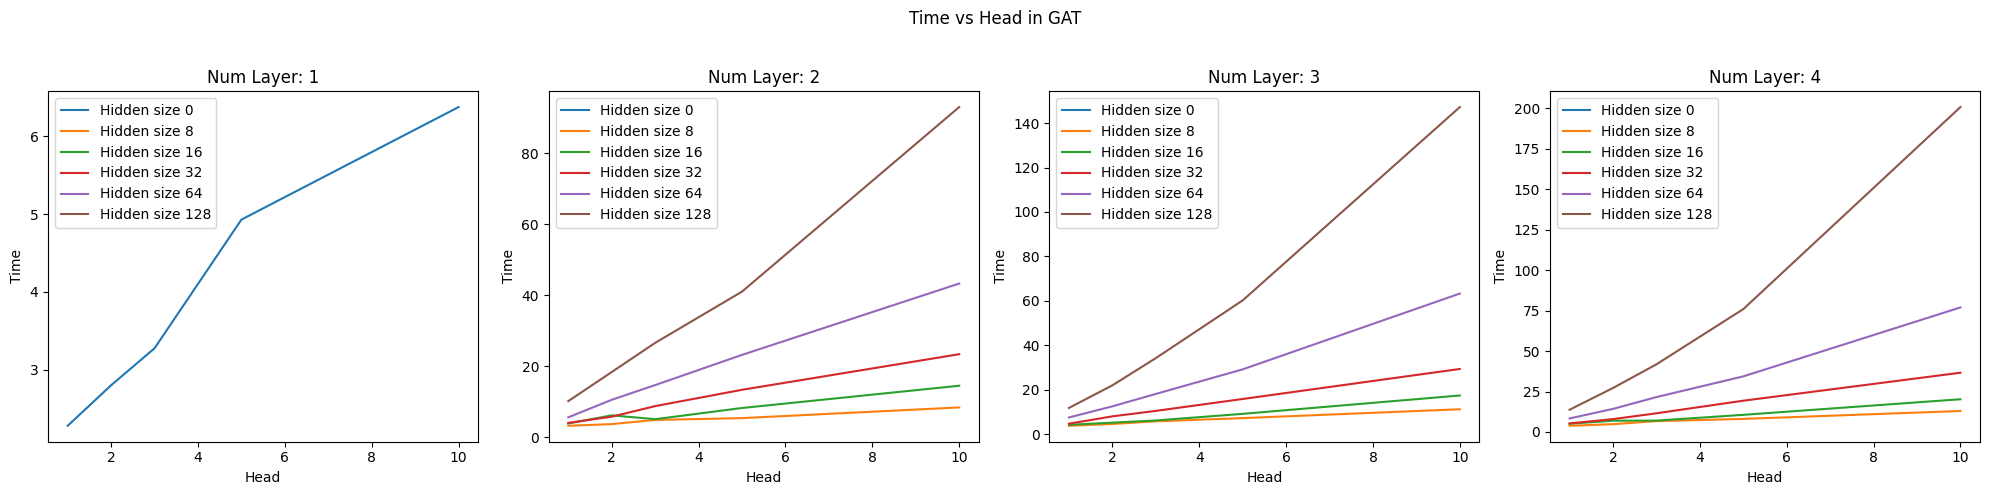

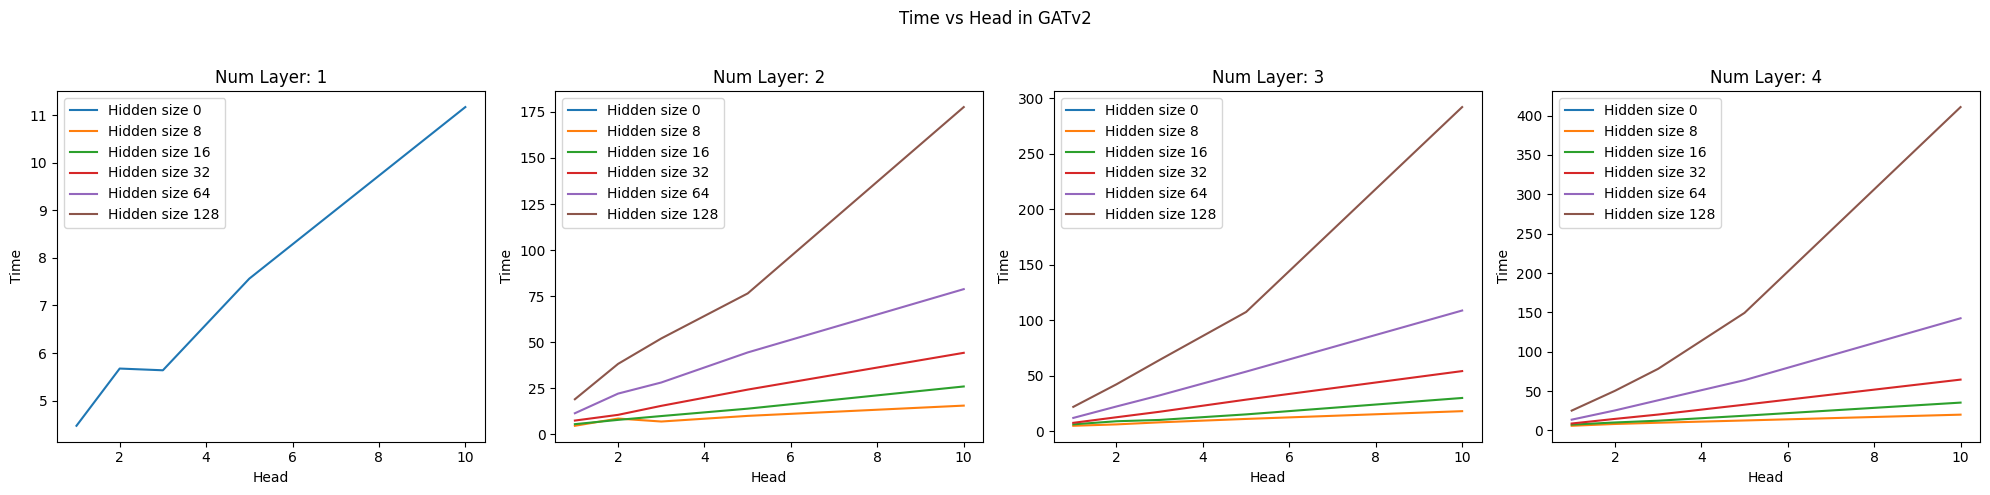

In [17]:
plot_head('citeseer','Time')

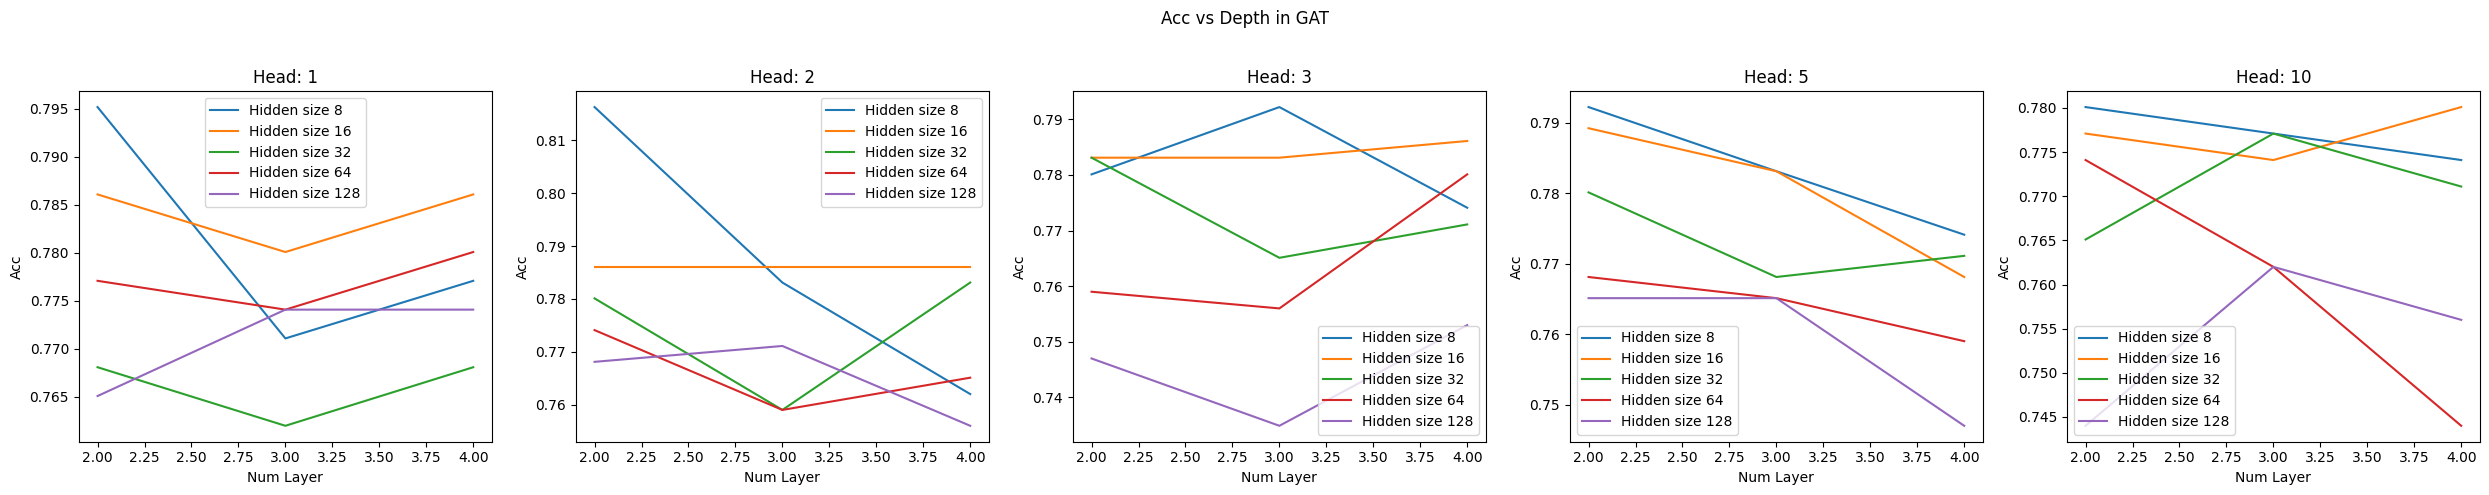

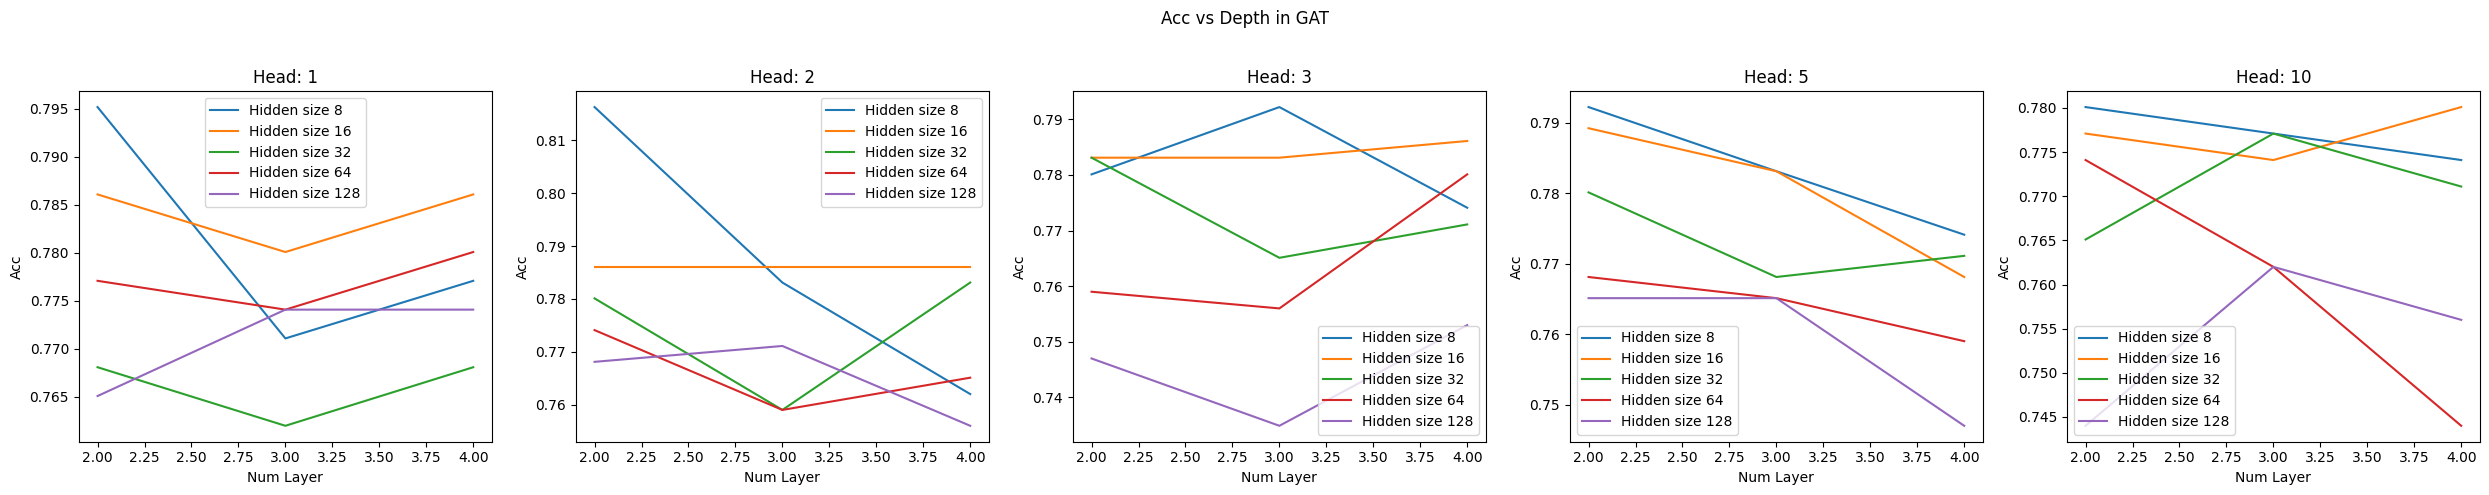

In [22]:
plot_depth_head('citeseer','Acc')

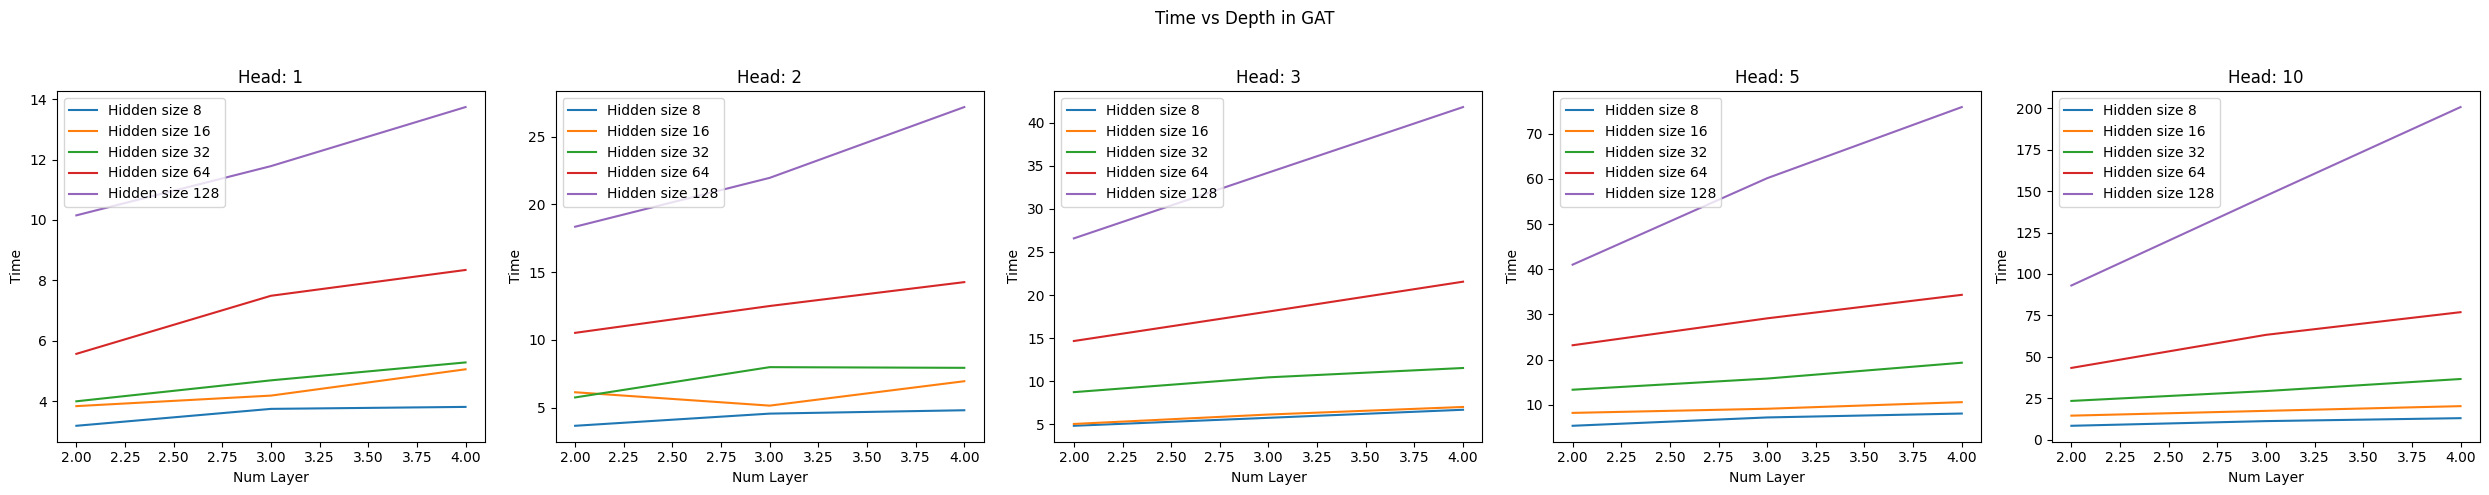

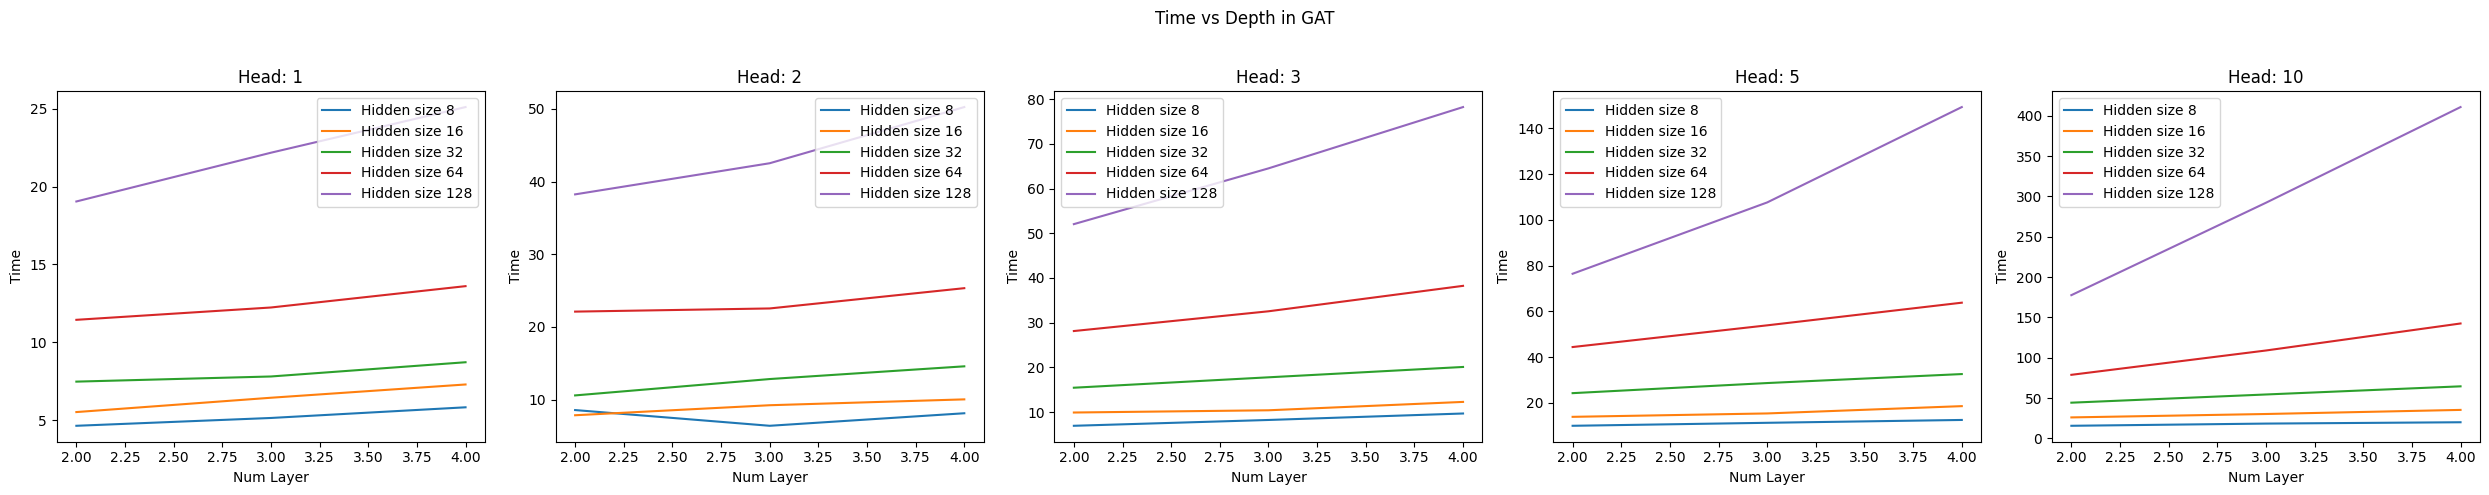

In [23]:
plot_depth_head('citeseer','Time')

### CoraFull

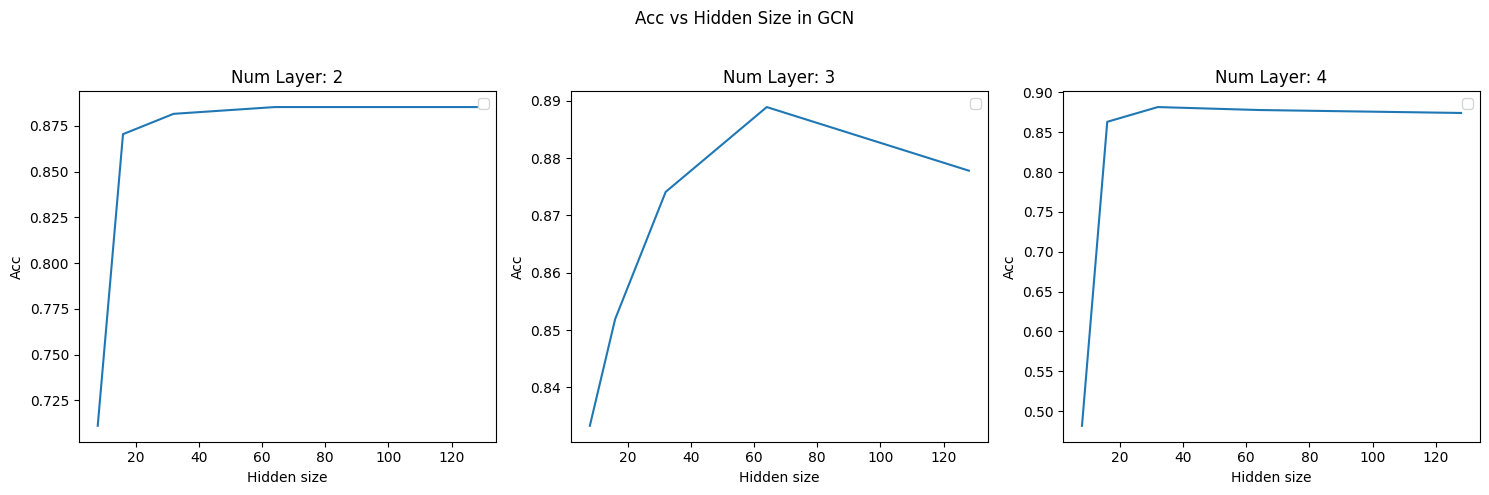

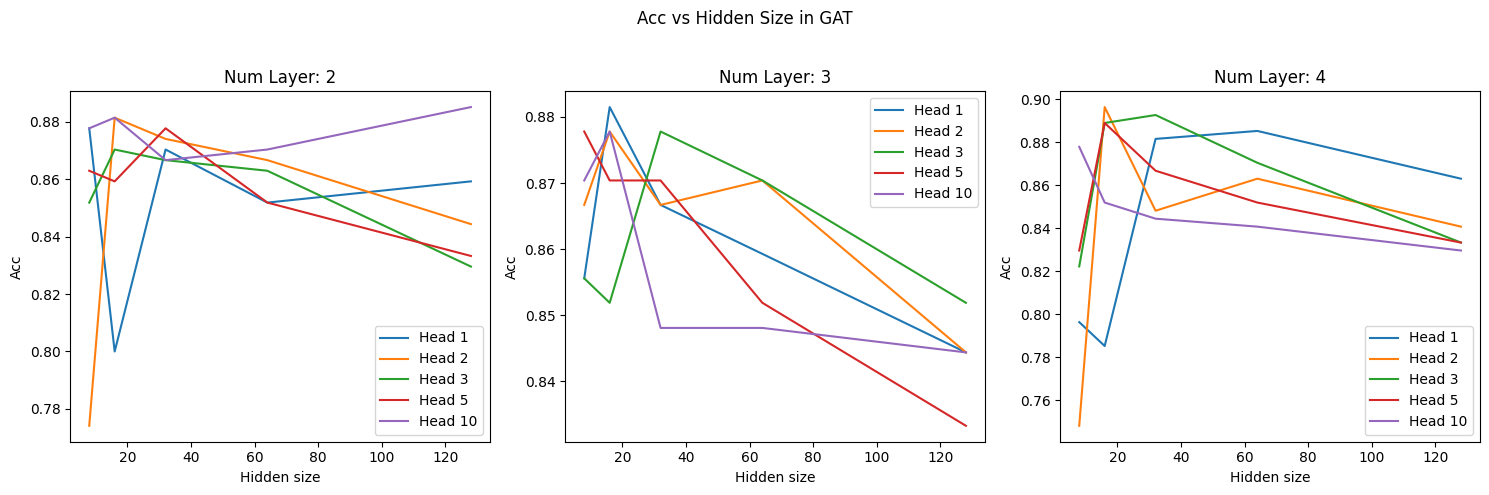

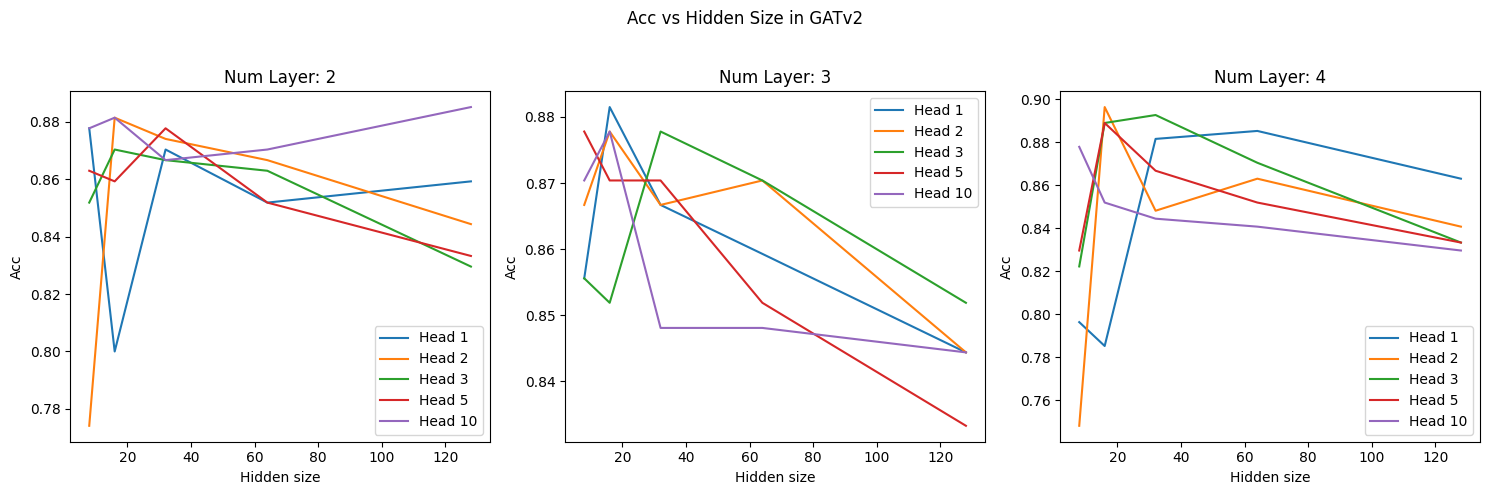

In [24]:
plot_hidden_layer('CoraFull','Acc')

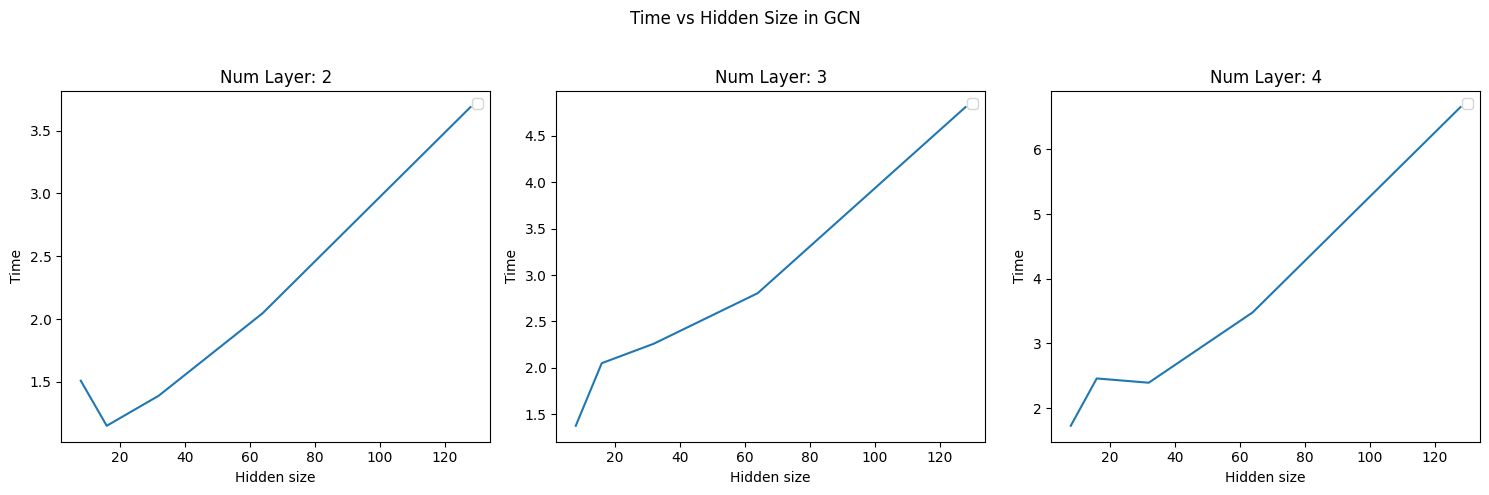

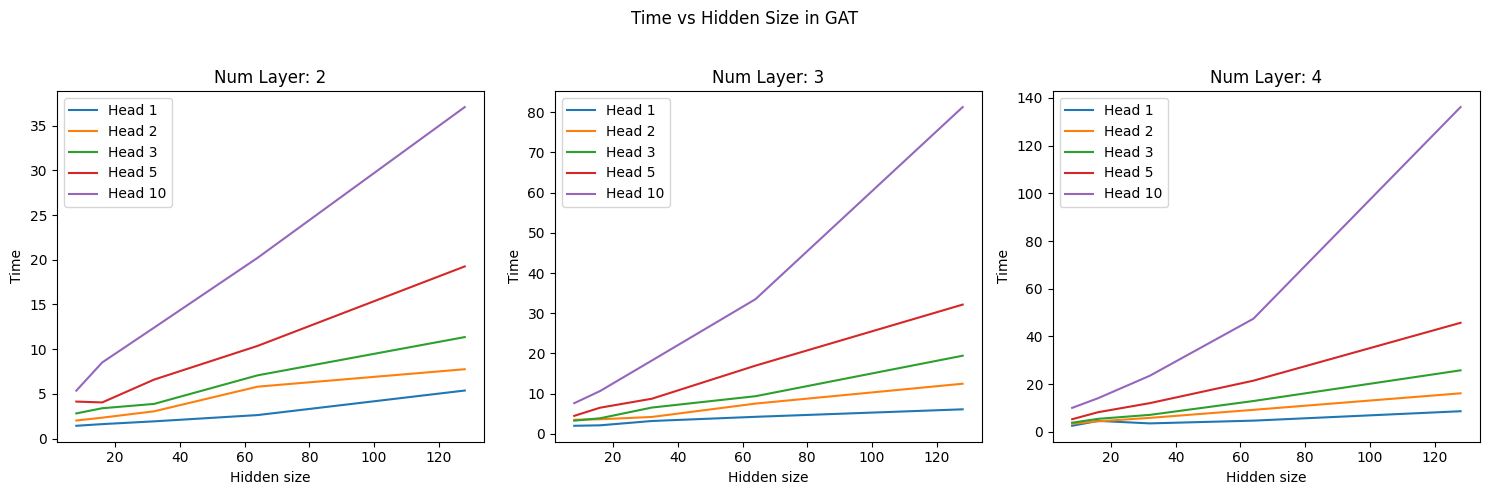

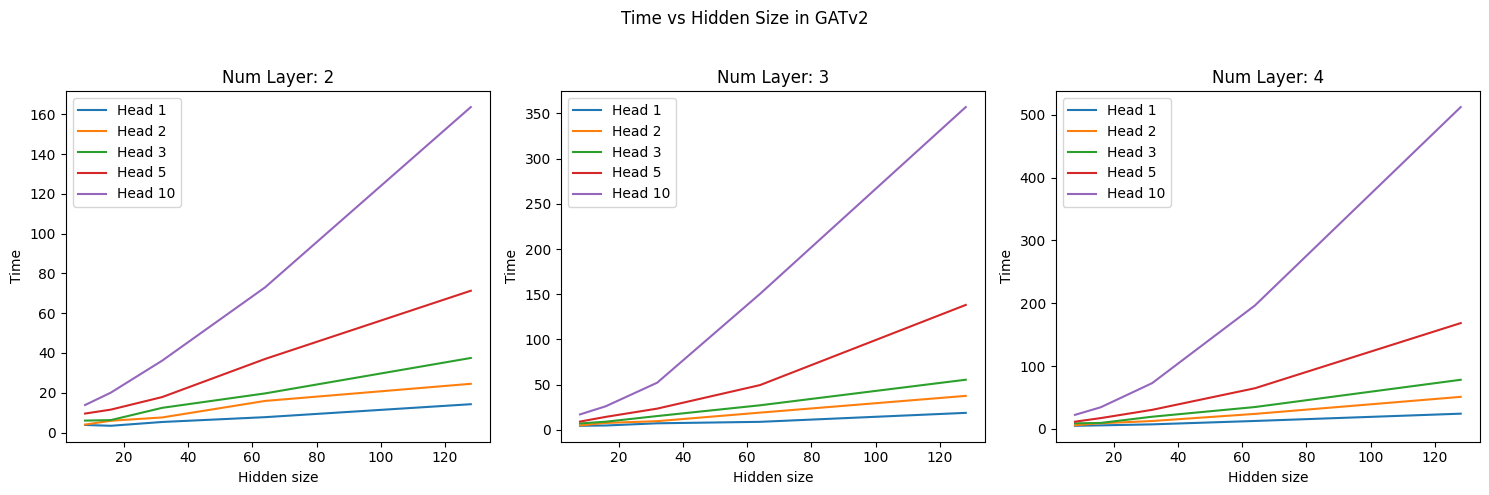

In [25]:
plot_hidden_layer('CoraFull','Time')

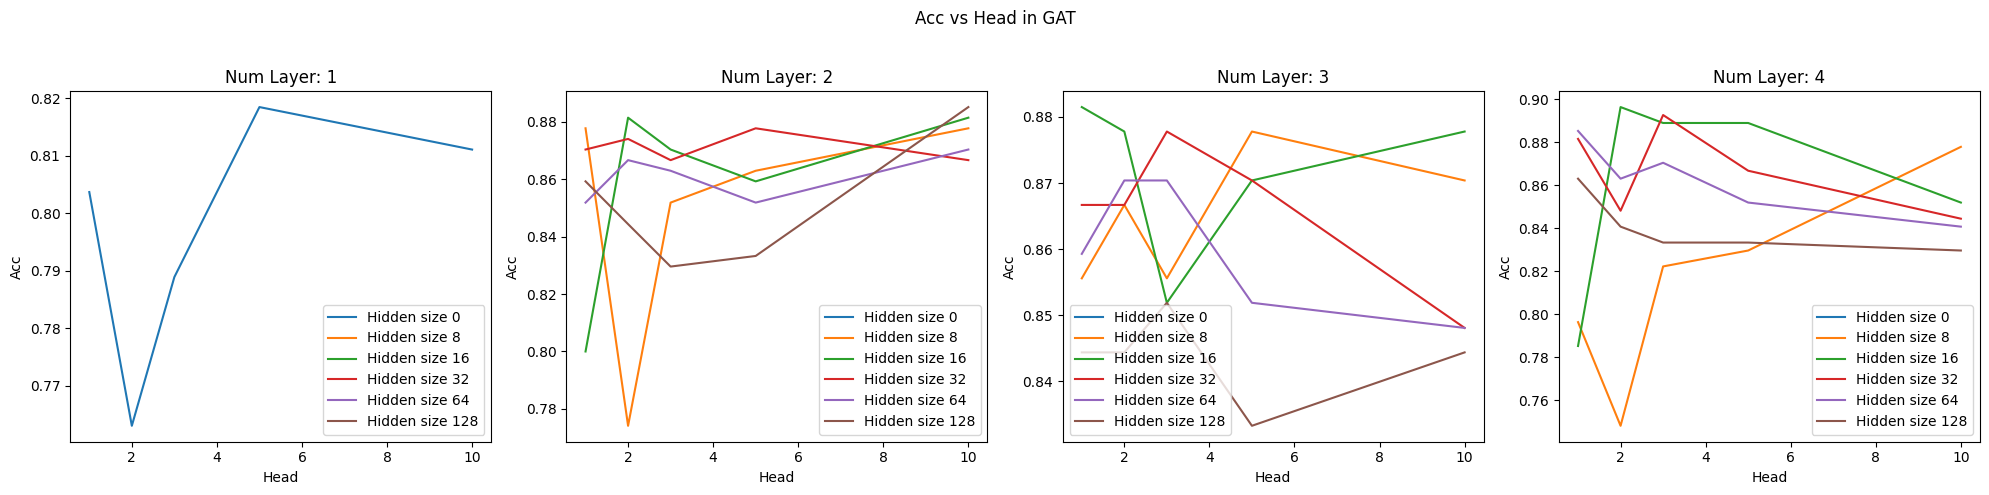

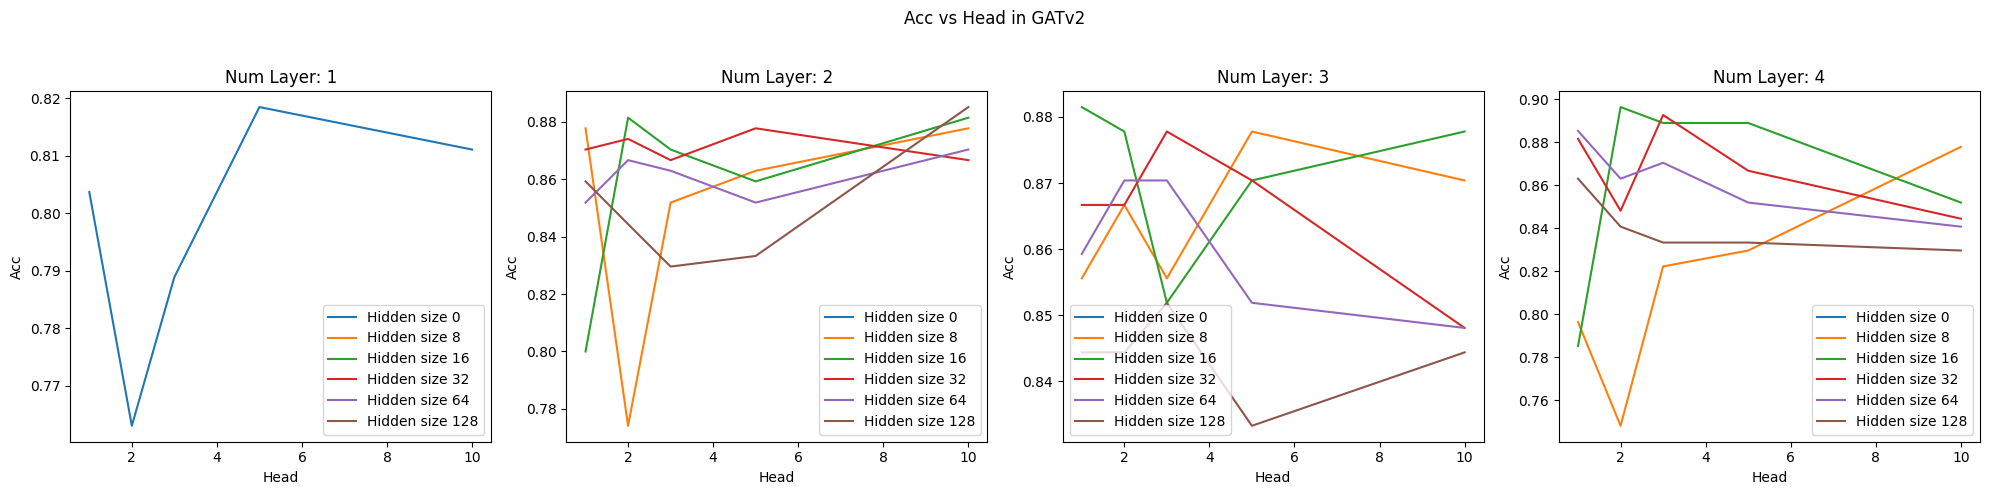

In [26]:
plot_head('CoraFull','Acc')

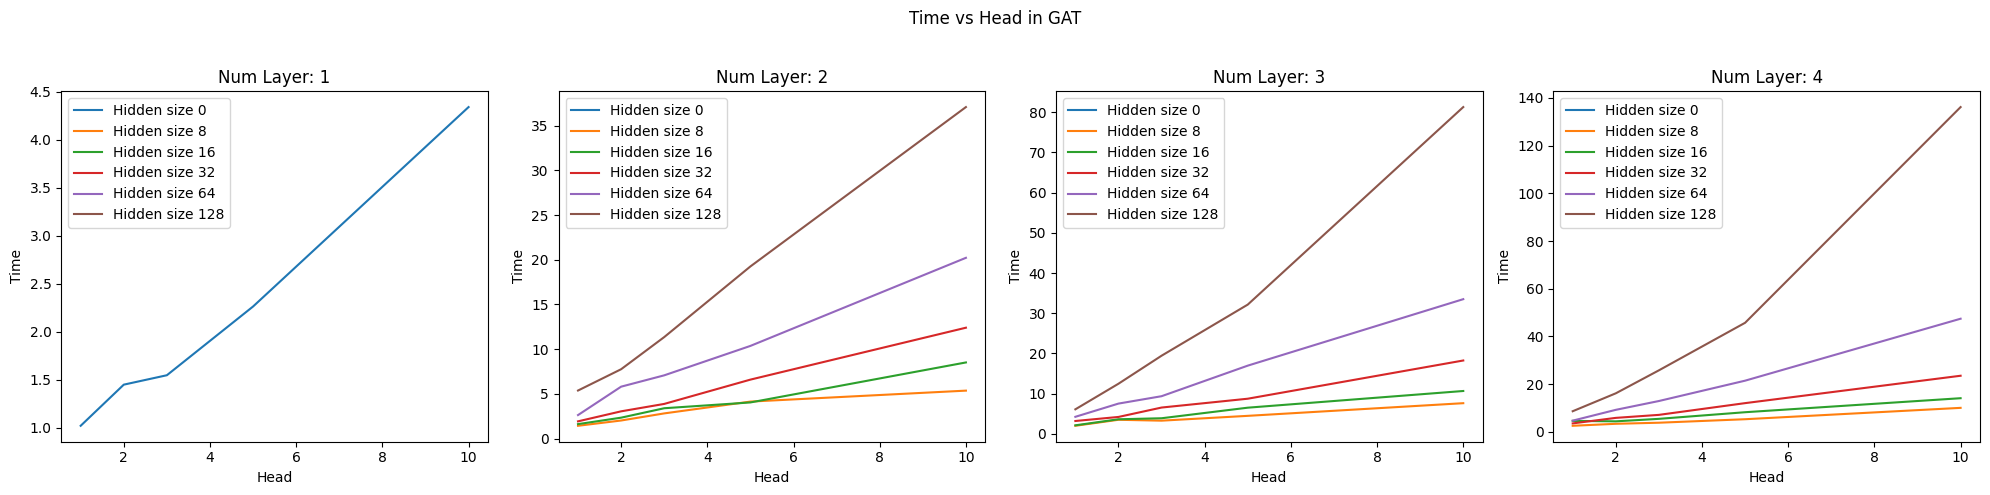

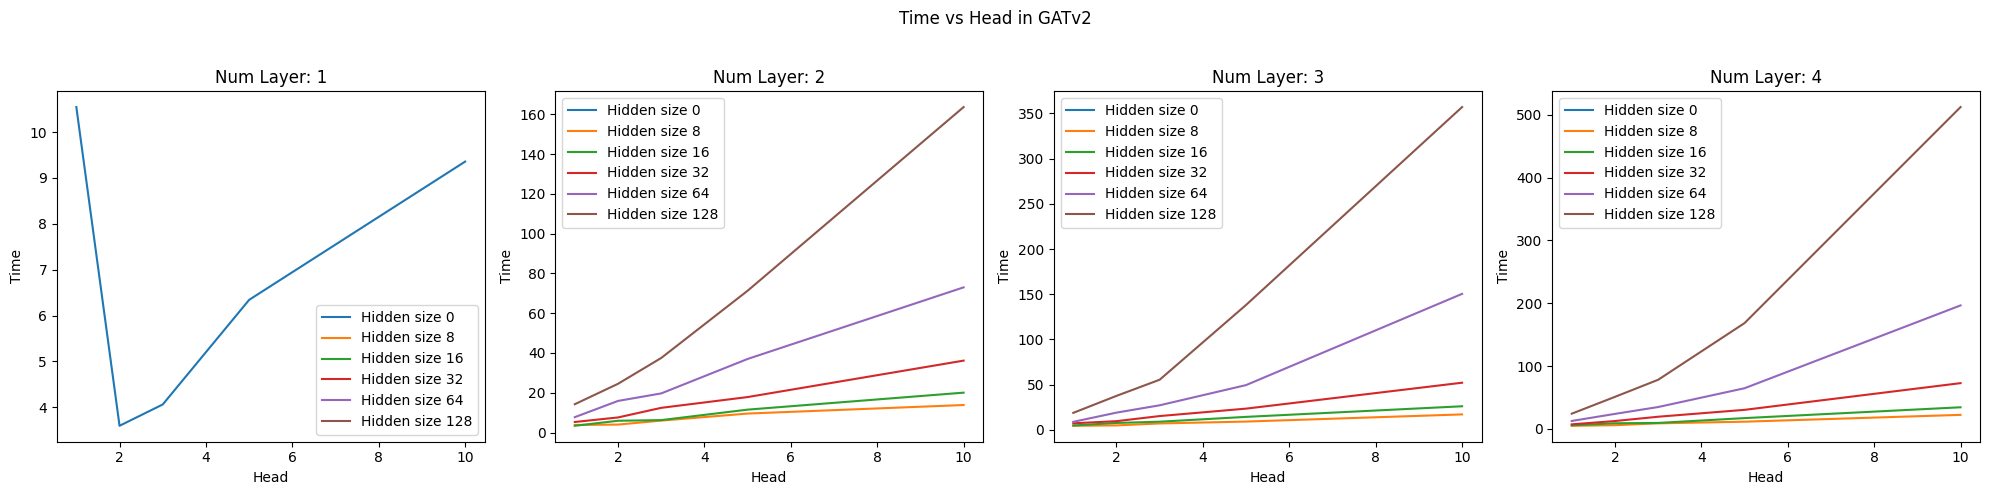

In [27]:
plot_head('CoraFull','Time')

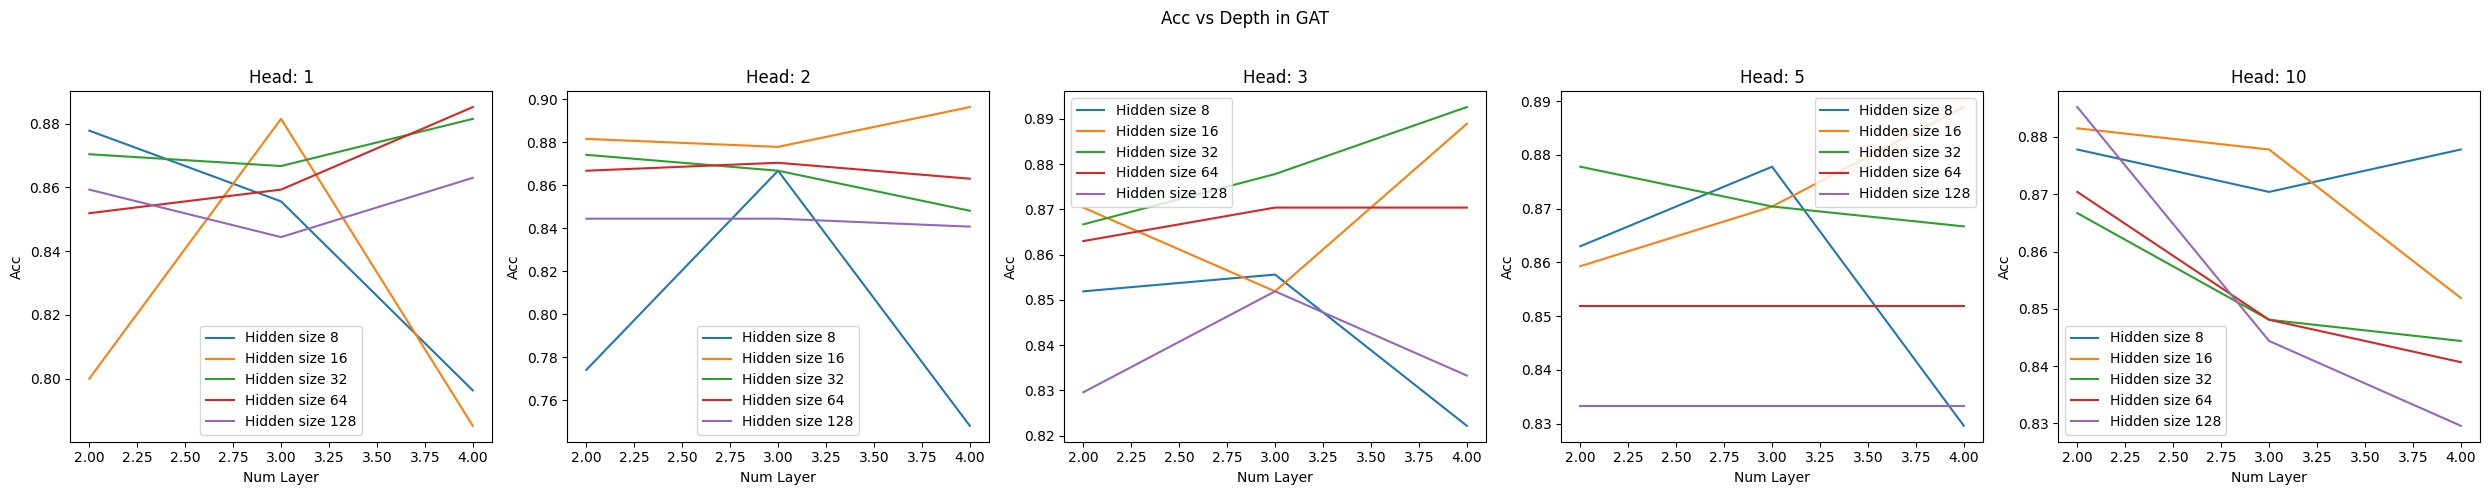

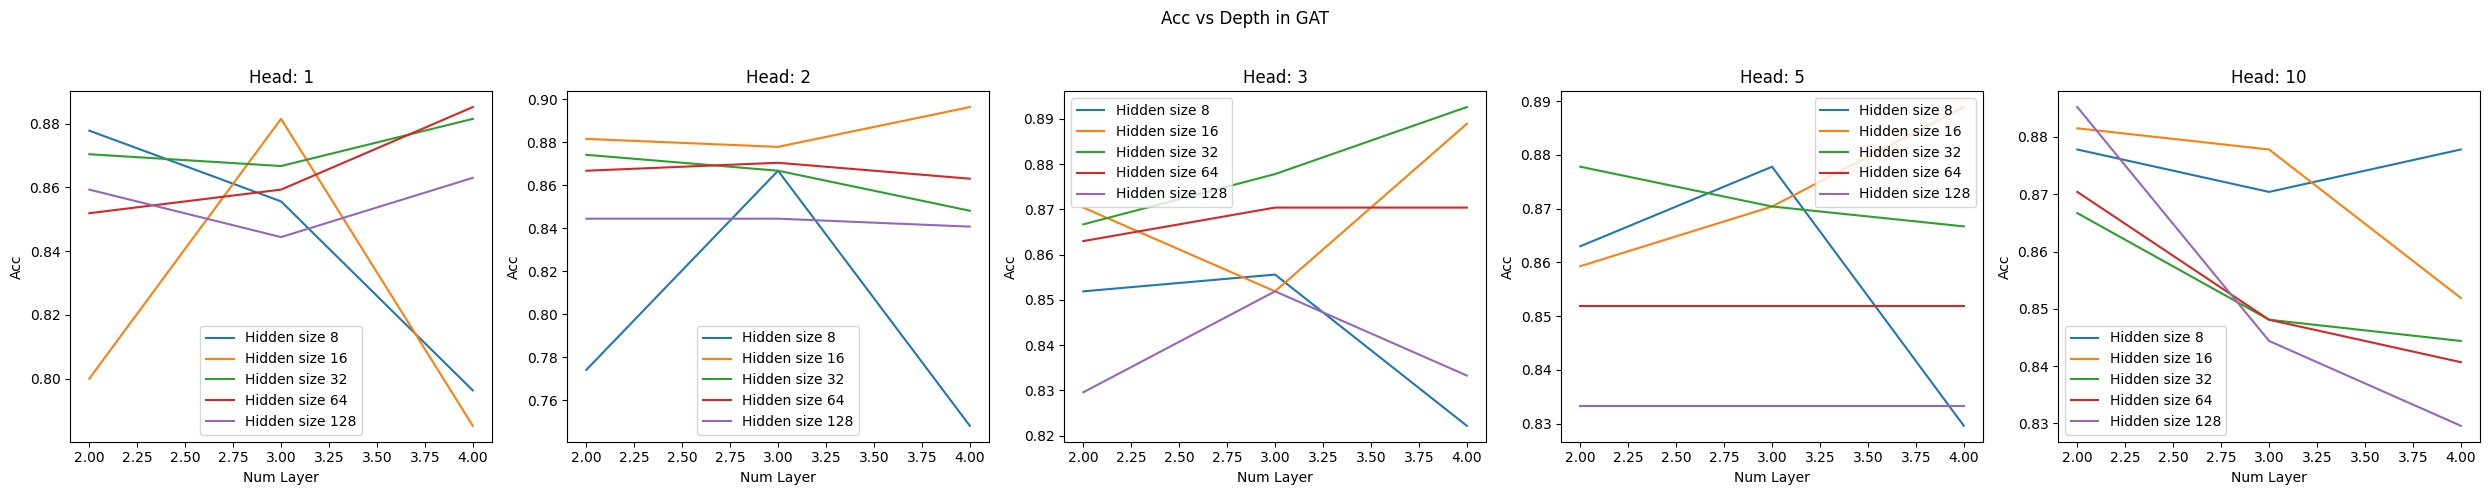

In [28]:
plot_depth_head('CoraFull','Acc')

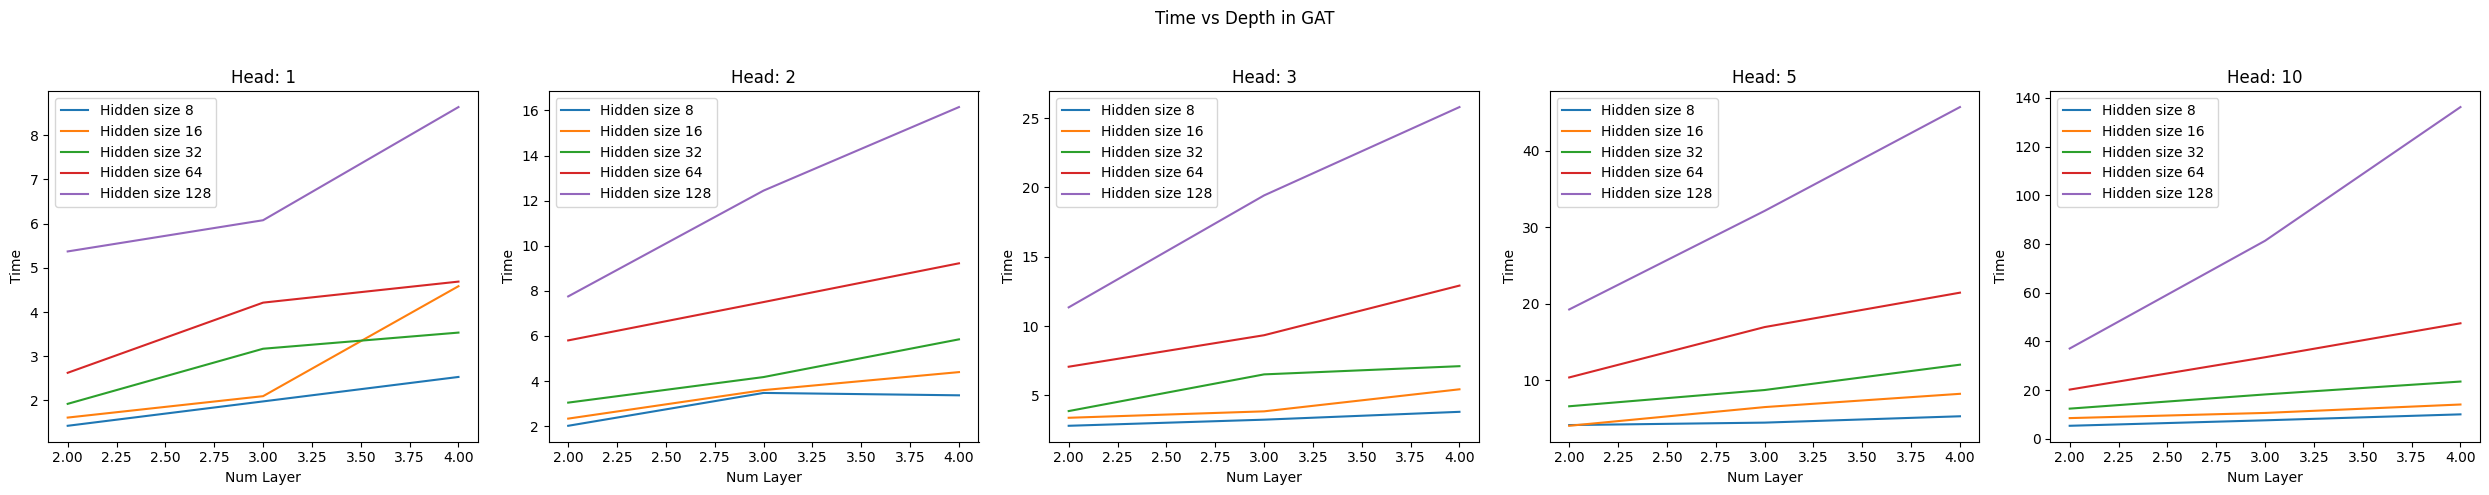

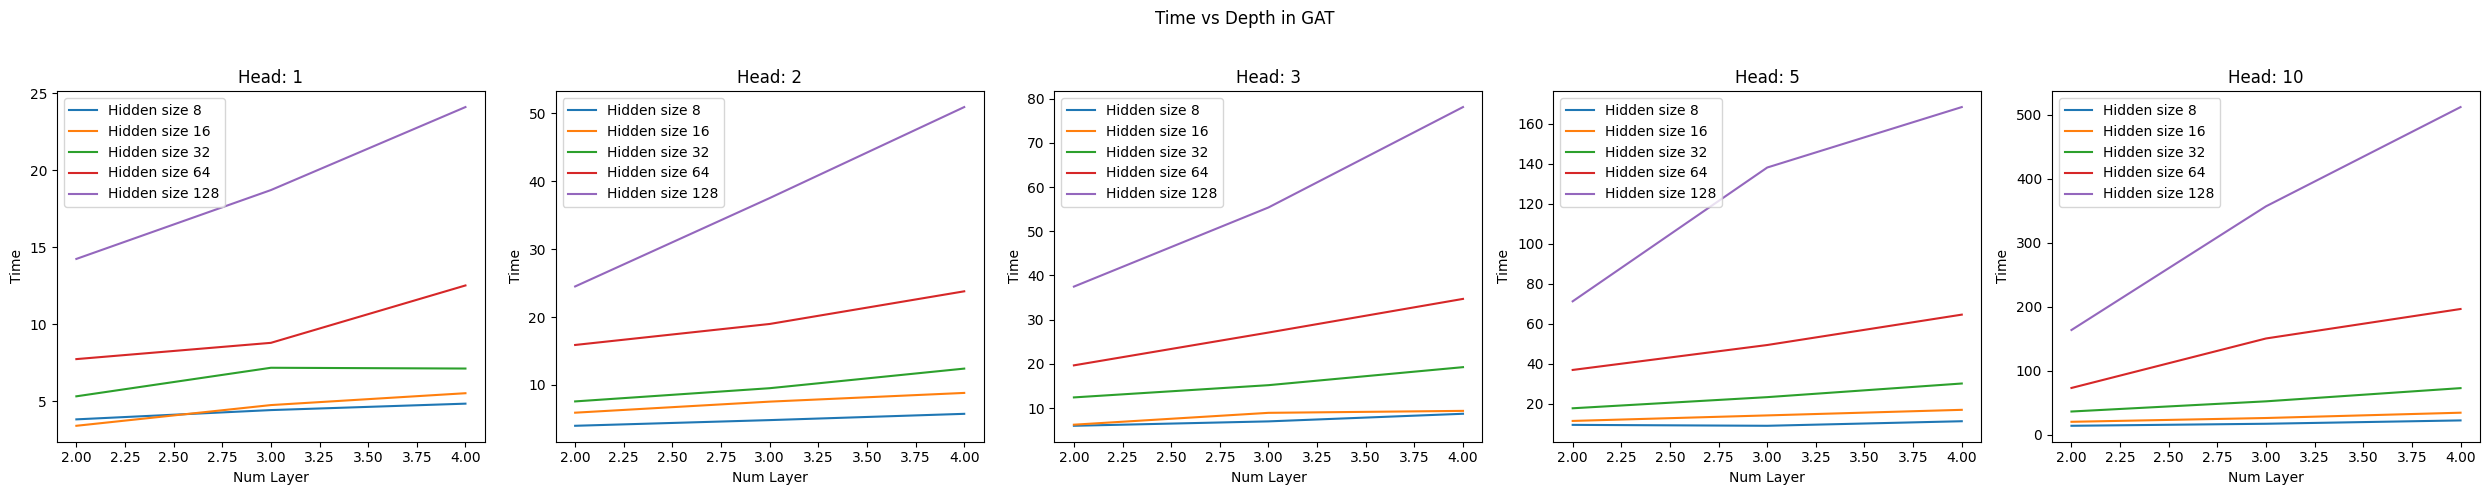

In [29]:
plot_depth_head('CoraFull','Time')